In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

from tqdm import tqdm
import multiprocessing as mp
import bilby
import numpy as np
from pycbc.waveform import get_td_waveform, taper_timeseries
from gwmat import point_lens
import matplotlib.pyplot as plt
import gwmat
import os
import sys
from pycbc.detector.ground import Detector
import pycbc
import bilby
from bilby.gw.prior import BBHPriorDict

import corner
from modules.gw_utils import scale_signal
import torch
from torch.utils.data import Dataset, DataLoader

from gwtorch.modules.gw_utils import inject_noise_with_target_SNR

from nflows.flows import Flow
from nflows.distributions import StandardNormal
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.autoregressive import MaskedPiecewiseRationalQuadraticAutoregressiveTransform
from nflows.nn.nets import ResidualNet
from nflows.transforms import CompositeTransform, RandomPermutation

In [2]:
num_samples = 6000
f_lower = 20.0       

priors = BBHPriorDict()

for key in ['a_1', 'a_2', 'tilt_1', 'tilt_2', 'theta_jn', 'phi_12', 'phi_jl', 'luminosity_distance', 'psi', 'phase']:
    priors.pop(key, None)

priors['mass_1'].minimum = 10
priors['mass_2'].minimum = 10
priors['chirp_mass'] = bilby.gw.prior.UniformInComponentsChirpMass(name='chirp_mass', minimum=10, maximum=100)
priors['mass_ratio'] = bilby.gw.prior.UniformInComponentsMassRatio(name='mass_ratio', minimum=0.1, maximum=1)
priors['spin1z'] = bilby.core.prior.Uniform(name='spin1z', minimum=-0.9, maximum=0.9)
priors['spin2z'] = bilby.core.prior.Uniform(name='spin2z', minimum=-0.9, maximum=0.9)
priors['coa_phase'] = bilby.core.prior.Uniform(name='coa_phase', minimum=0.0, maximum=2 * np.pi)
priors['polarization'] = bilby.core.prior.Uniform(minimum=0., maximum=np.pi, boundary="periodic")
priors['Log_Mlz'] = bilby.core.prior.Uniform(minimum=2, maximum=5)
priors['yl'] = bilby.core.prior.PowerLaw(alpha=1, minimum=0.01, maximum=1.0)

parameters_list = priors.sample(num_samples)

samples = [
    {key: parameters_list[key][i] for key in parameters_list}
    for i in range(num_samples)
]

print(f"Length of parameters_list: {len(samples)}")

Length of parameters_list: 6000


In [3]:
samples[0].keys()

dict_keys(['mass_ratio', 'chirp_mass', 'dec', 'ra', 'spin1z', 'spin2z', 'coa_phase', 'polarization', 'Log_Mlz', 'yl'])

In [4]:
def waveform(num):
    parameters = samples[num].copy()

    # Convert masses
    mass1, mass2 = bilby.gw.conversion.chirp_mass_and_mass_ratio_to_component_masses(
        parameters['chirp_mass'], parameters['mass_ratio']
    )

    m_lens = np.power(10., parameters.pop("Log_Mlz"))
    y_lens = parameters.pop("yl")

    # Generate unlensed waveform
    sp, sc = get_td_waveform(
        approximant='SEOBNRv4_opt',
        mass1=mass1,
        mass2=mass2,
        spin1z=parameters['spin1z'],
        spin2z=parameters['spin2z'],
        distance=300,
        delta_t=1.0 / 4096,
        coa_phase=parameters['coa_phase'],
        f_lower=f_lower,
    )

    # Frequency-domain lensing
    sp_freq = sp.to_frequencyseries(delta_f=sp.delta_f)
    sc_freq = sc.to_frequencyseries(delta_f=sc.delta_f)
    fs1 = sp_freq.sample_frequencies

    # Ffs_sp = np.vectorize(lambda f: gwmat.cythonized_point_lens.Ff_effective(f, ml=m_lens, y=y_lens))(fs1)
    Ffs = [gwmat.cythonized_point_lens.Ff_effective(f, ml=m_lens, y=y_lens) for f in fs1]
    time_Delay = point_lens.time_delay(ml=m_lens, y=y_lens)

    sp_lensed = pycbc.types.FrequencySeries(np.conj(Ffs) * np.asarray(sp_freq),
                                            delta_f=sp_freq.delta_f).cyclic_time_shift(-1 * (0.1 + time_Delay))
    sc_lensed = pycbc.types.FrequencySeries(np.conj(Ffs) * np.asarray(sc_freq),
                                            delta_f=sc_freq.delta_f).cyclic_time_shift(-1 * (0.1 + time_Delay))

    sp_lensed = sp_lensed.to_timeseries(delta_t=sp_lensed.delta_t)
    sc_lensed = sc_lensed.to_timeseries(delta_t=sc_lensed.delta_t)

    # Detector projection
    detector = Detector('H1')
    lensed_signal = detector.project_wave(
        sp_lensed, sc_lensed,
        ra=parameters['ra'], dec=parameters['dec'], polarization=parameters['polarization']
    )
    lensed_signal = taper_timeseries(lensed_signal, tapermethod="TAPER_STARTEND", return_lal=False)

    # Inject noise with target SNR
    target_snr = np.random.randint(15, 100)
    lensed_noisy, _, distance, _ = inject_noise_with_target_SNR(
        lensed_signal, parameters, mass1, mass2, m_lens, y_lens,
        target_snr, num, gw_signal_type='lensed',
        peak_window=(2.0, 2.2), detector=detector
    )

    # Update local copy of parameters
    parameters['distance'] = distance
    parameters['Log_Mlz'] = np.log10(m_lens)
    parameters['yl'] = y_lens

    lensed_noisy = lensed_noisy.crop(left=24, right=0)

    return np.array(lensed_noisy), parameters

In [5]:
def simulator(num):
    waveform_array, updated_params = waveform(num)
    return updated_params, waveform_array

def simulate_one(ii):
    theta_val, y_val = simulator(ii)
    return theta_val, y_val

In [6]:
num_simulations = num_samples

if __name__ == "__main__":
    with mp.Pool(processes=mp.cpu_count()) as pool:
        results = pool.map(simulate_one, range(num_simulations))

    # Unzip results
    updated_samples, data_vals = zip(*results)
    updated_samples = list(updated_samples)
    data_vals = list(data_vals)

    # Replace old samples with updated ones
    samples = updated_samples

    theta_vals, data_vals = zip(*results)

In [7]:
samples[0].keys()

dict_keys(['mass_ratio', 'chirp_mass', 'dec', 'ra', 'spin1z', 'spin2z', 'coa_phase', 'polarization', 'distance', 'Log_Mlz', 'yl'])

In [8]:
theta_vals = [list(d.values()) for d in theta_vals]

In [9]:
# convert to torch tensors
theta_vals = torch.from_numpy(np.array(theta_vals)).to(torch.float32)
data_vals = torch.from_numpy(np.array(data_vals)).to(torch.float32)

In [10]:
# ---- SAVE ----
torch.save({
    'theta_vals': theta_vals,
    'data_vals': data_vals,
    'parameters': list(samples[0].keys())
}, 'dataset.pt')

In [ ]:
# ---- LOAD ----
checkpoint = torch.load('dataset.pt')
theta_vals = checkpoint['theta_vals']
data_vals = checkpoint['data_vals']

# recreate dataset
dataset = DataGenerator()


In [ ]:
# create dataset
class DataGenerator(Dataset):
    def __len__(self):
        return num_simulations

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return theta_vals[idx], data_vals[idx]

dataset = DataGenerator()

# create dataloaders - 80/10/10 split
train_set_size = int(0.8 * num_simulations)
val_set_size = int(0.1 * num_simulations)
test_set_size = int(0.1 * num_simulations)

train_data, val_data, test_data = torch.utils.data.random_split(
    dataset, [train_set_size, val_set_size, test_set_size])

train_data_loader = DataLoader(
    train_data, batch_size=256,
    shuffle=True
)

val_data_loader = DataLoader(
    val_data, batch_size=256,
    shuffle=True
)

test_data_loader = DataLoader(
    test_data, batch_size=1,
    shuffle=False
)

In [11]:
len(train_data_loader), len(val_data_loader), len(test_data_loader)

(13, 2, 400)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [16]:
num_transforms = 24
num_blocks = 24
hidden_features = 50

context_features = data_vals[0].shape[0]
parameter_space_dim = len(samples[0].keys())

base_dist = StandardNormal([parameter_space_dim])  

transforms = []

# for _ in range(num_transforms):
#     block = [
#         MaskedAffineAutoregressiveTransform(
#                 features=parameter_space_dim, 
#                 hidden_features=hidden_features,
#                 context_features=context_features,
#                 num_blocks=num_blocks,
#                 activation=torch.tanh,
#                 use_batch_norm=True,
#                 use_residual_blocks=False,
#         ),
#         RandomPermutation(features=parameter_space_dim)
#     ]
#     transforms += block

for _ in range(num_transforms):
    block = [
        MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
            features=parameter_space_dim,
            hidden_features=hidden_features,
            context_features=context_features,
            num_blocks=num_blocks,
            tails='linear',          # You can also try 'circular' or 'constant' if desired
            tail_bound=3.0,          # Adjust as needed; default 3.0 is common
            num_bins=8,              # Number of bins for the spline, common: 8~16
            dropout_probability=0.0, # Adjust if you want dropout
            activation=torch.tanh,
            use_batch_norm=True,
            use_residual_blocks=False,
        ),
        RandomPermutation(features=parameter_space_dim)
    ]
    transforms += block

transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist).to(device)

In [17]:
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

In [18]:
for i in range(200):
    flow.train()
    train_loss_total = 0.0

    train_loader = tqdm(train_data_loader, desc=f"Epoch {i+1} [Train]", leave=False)
    for idx, val in enumerate(train_loader):
        theta, data = val
        theta = theta.to(device)
        data = data.to(device)

        optimizer.zero_grad()
        loss = -flow.log_prob(theta, context=data).mean()
        loss.backward()
        optimizer.step()
        
        train_loss_total += loss.item()
        train_loader.set_postfix(loss=loss.item())

    scheduler.step()
    train_loss_avg = train_loss_total / len(train_data_loader)

    flow.eval()
    val_loss_total = 0.0
    with torch.no_grad():
        val_loader = tqdm(val_data_loader, desc=f"Epoch {i+1} [Val]", leave=False)
        for idx, val in enumerate(val_loader):
            theta, data = val
            theta = theta.to(device)
            data = data.to(device)

            val_loss_batch = -flow.log_prob(theta, context=data).mean()
            val_loss_total += val_loss_batch.item()
            val_loader.set_postfix(loss=val_loss_batch.item())

    val_loss_avg = val_loss_total / len(val_data_loader)

    if i == 0 or (i+1) % 10 == 0:
        print(f"[Epoch {i+1}] Train Loss: {train_loss_avg:.4f} | Val Loss: {val_loss_avg:.4f}")

[Epoch 1] Train Loss: 1135790.2548 | Val Loss: 1542658.1875


[Epoch 10] Train Loss: 1154078.6298 | Val Loss: 1561302.0625


KeyboardInterrupt: 

In [ ]:
# torch.save(flow.state_dict(), "flow_bbh.pth")

In [ ]:
theta_test, data_test = next(iter(test_data_loader))
theta_test = theta_test.to(device)
data_test = data_test.to(device)
with torch.no_grad():
        posterior_samples = flow.sample(5000, context=data_test.reshape(tuple(data_test.shape)))

theta_test = theta_test.squeeze(0)

In [ ]:
theta_test

tensor([ 1.4652e-01,  2.9427e+01, -5.6076e-03,  4.0864e+00, -5.3683e-01,
         6.2789e-02,  9.7010e-01,  2.0697e+00,  1.3236e+02,  4.1999e+00,
         8.1624e-01], device='cuda:0')

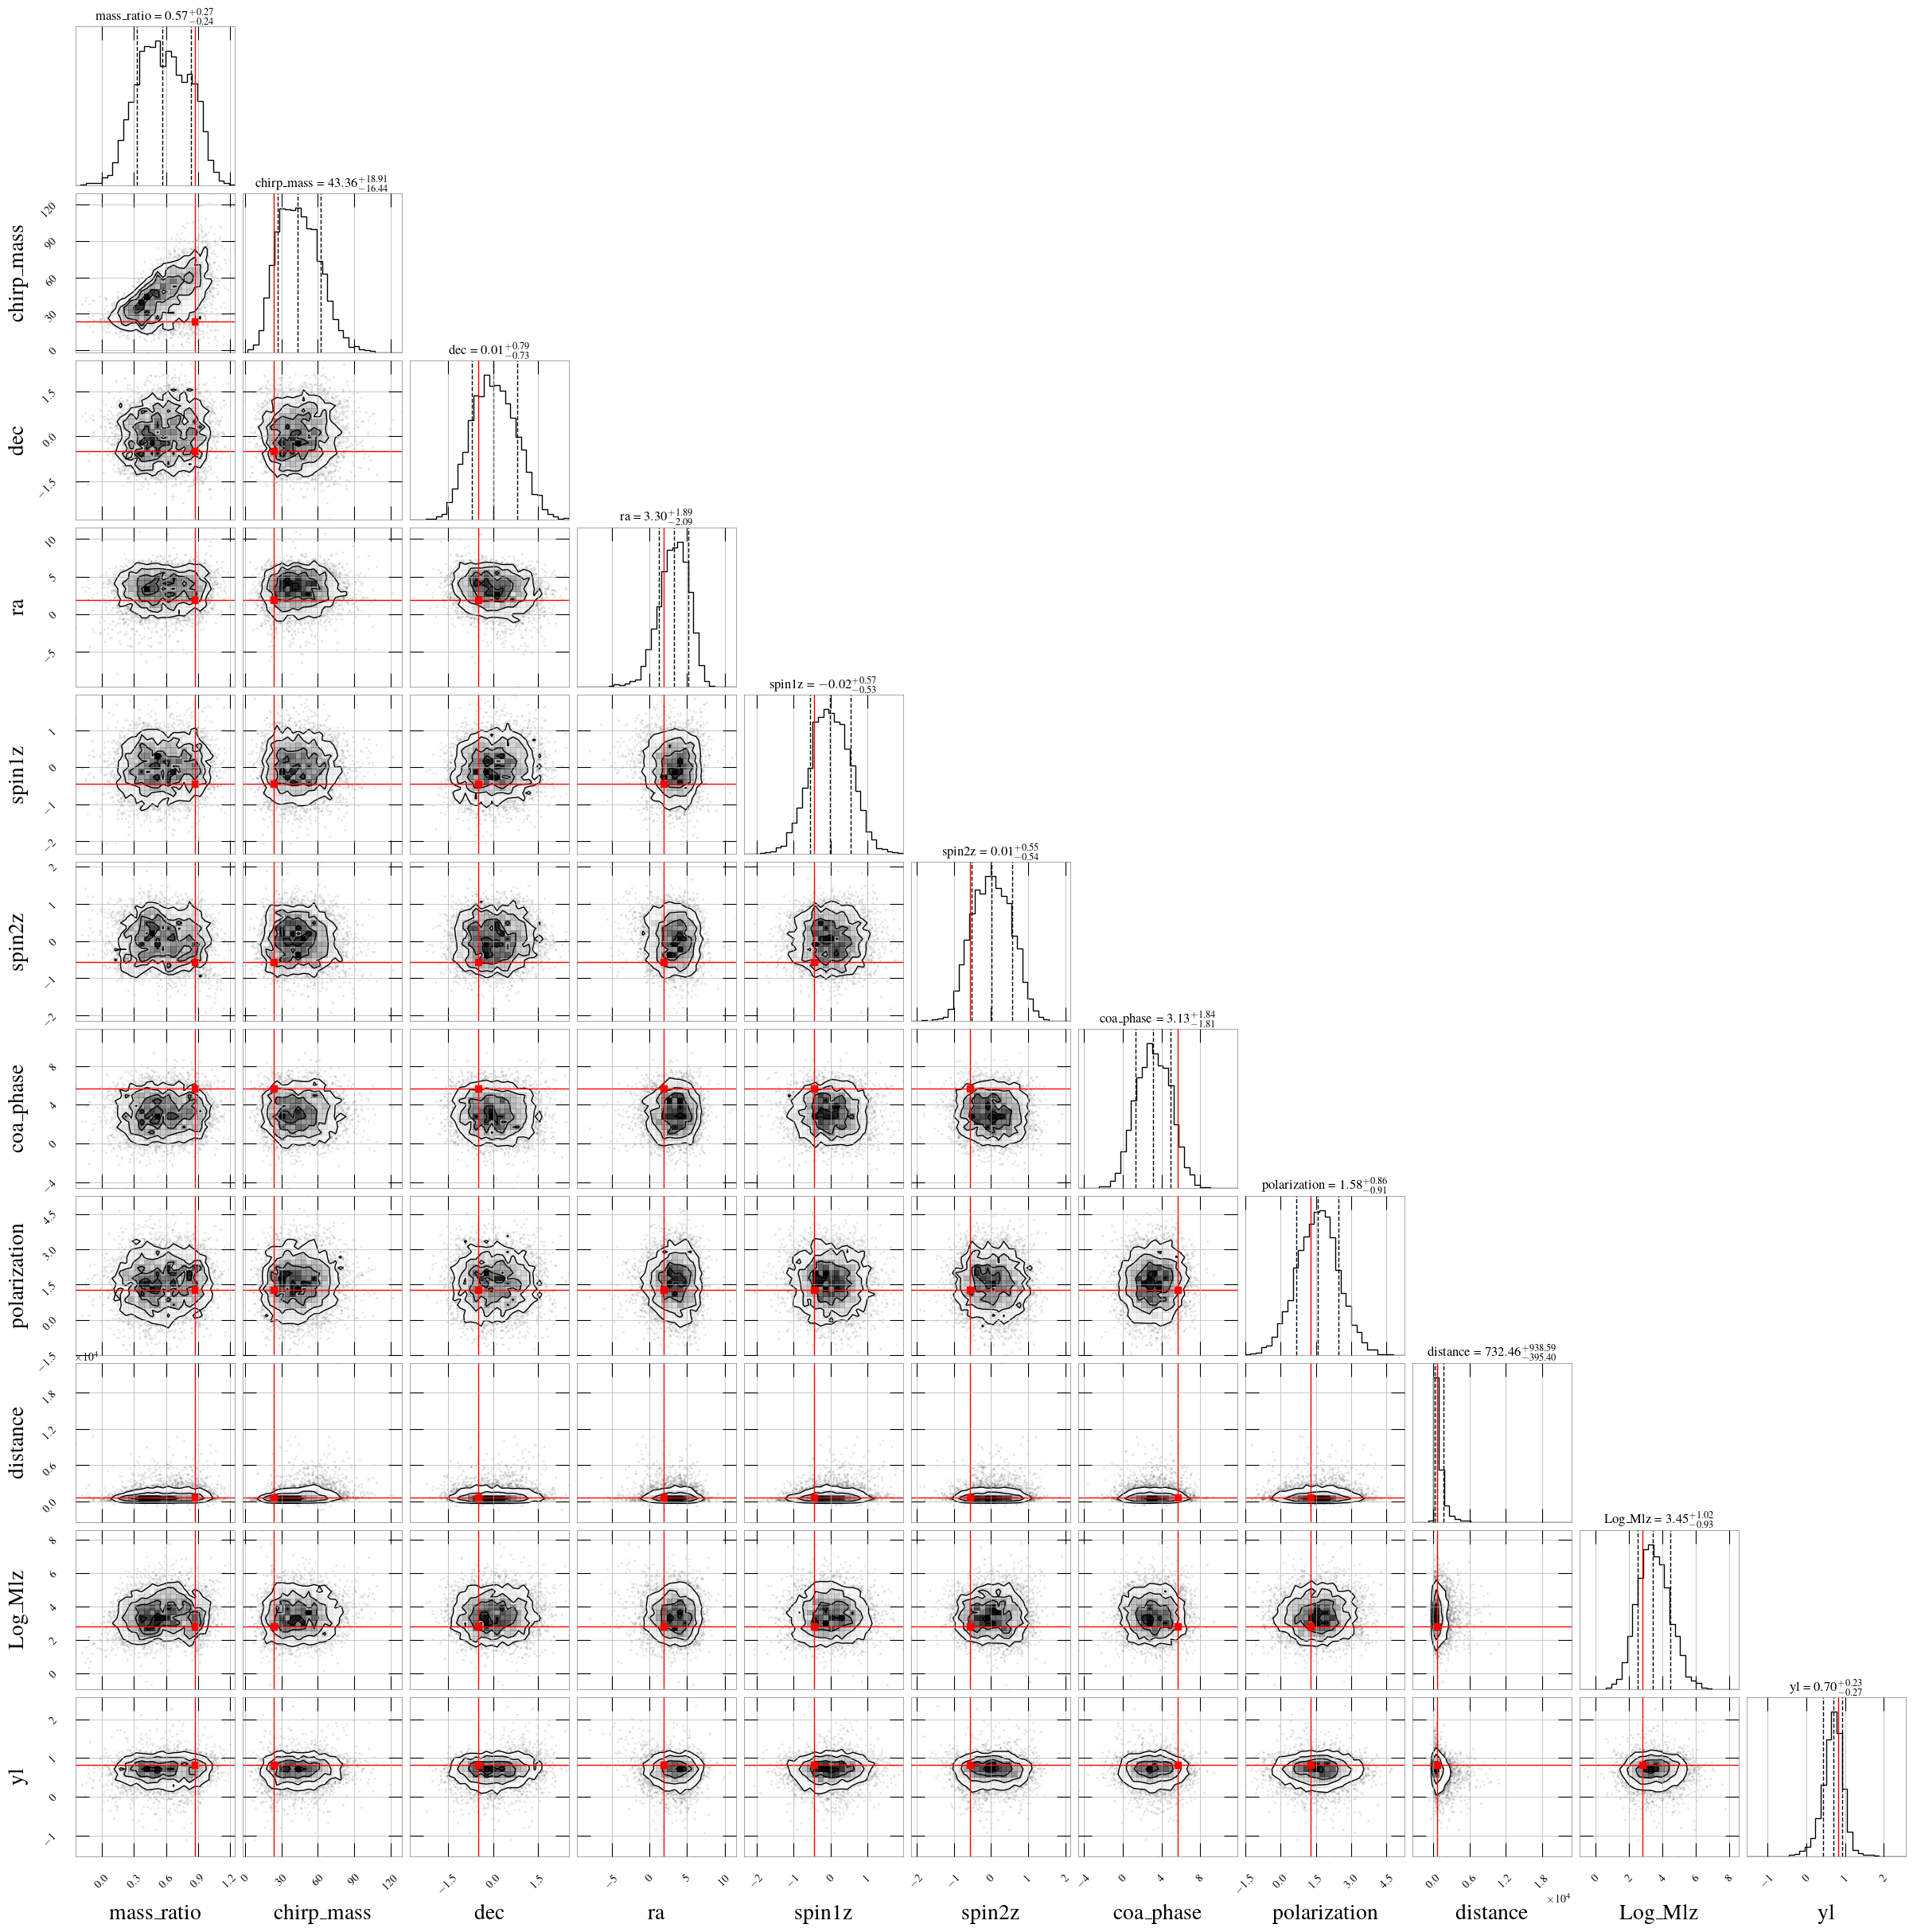

In [ ]:
from matplotlib import rc

data = posterior_samples.squeeze(0).cpu().numpy()

rc('text', usetex=True)
rc('font', family='serif')
rc('font', serif='times')
rc('mathtext', default='sf')
rc("lines", markeredgewidth=1)
rc("lines", linewidth=1)
rc('axes', labelsize=20)
rc("axes", linewidth=0.5)
rc('xtick', labelsize=10)
rc('ytick', labelsize=10)
rc('legend', fontsize=10)
rc('ytick', right=True, direction='in')
rc('xtick', top=True, direction='in')
rc('xtick.major', pad=15)
rc('ytick.major', pad=15)
rc('xtick.major', size=12)
rc('ytick.major', size=12)
rc('xtick.minor', size=7)
rc('ytick.minor', size=7)

figure = corner.corner(
    data,
    bins=30,  # Number of bins
    labels=list(samples[0].keys()),
    quantiles=[0.16, 0.5, 0.84], 
    show_titles=True,
    title_kwargs={"fontsize": 12},
    truths=theta_test.cpu().numpy(),
    truth_color="red",
)

def set_tick_sizes_corner(fig, major=12, minor=7):
    for ax in fig.get_axes():
        for line in ax.xaxis.get_ticklines() + ax.yaxis.get_ticklines():
            line.set_markersize(major)
        for tick in ax.xaxis.get_minor_ticks() + ax.yaxis.get_minor_ticks():
            tick.tick1line.set_markersize(minor)
            tick.tick2line.set_markersize(minor)

set_tick_sizes_corner(figure)

# figure.savefig("Injection_PE.pdf", bbox_inches='tight')
plt.show()


In [ ]:
from modules.pp_plot_code import calculate_pp_values, compute_pp_statistics

In [ ]:
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import rc

# Configure matplotlib
rc('text', usetex=True)
rc('font', family='serif')
rc('font', serif='times')
rc('mathtext', default='sf')
rc("lines", markeredgewidth=1)
rc("lines", linewidth=1)
rc('axes', labelsize=20)
rc("axes", linewidth=0.5)
rc('xtick', labelsize=10)
rc('ytick', labelsize=10)
rc('legend', fontsize=10)
rc('ytick', right=True, direction='in')
rc('xtick', top=True, direction='in')
rc('xtick.major', pad=15)
rc('ytick.major', pad=15)
rc('xtick.major', size=12)
rc('ytick.major', size=12)
rc('xtick.minor', size=7)
rc('ytick.minor', size=7)

def set_tick_sizes(ax, major=12, minor=7):
    for line in ax.xaxis.get_ticklines() + ax.yaxis.get_ticklines():
        line.set_markersize(major)
    for tick in ax.xaxis.get_minor_ticks() + ax.yaxis.get_minor_ticks():
        tick.tick1line.set_markersize(minor)
        tick.tick2line.set_markersize(minor)

def plot_overlay_pp_plot(pp_values, parameter_names, confidence_level=0.95):

    n_tests = pp_values.shape[0]

    # Calculate 95% CI
    alpha = 1 - confidence_level
    alpha_lower_bound = stats.beta.ppf(alpha/2, np.arange(1, n_tests+1), n_tests - np.arange(1, n_tests+1) + 1)
    alpha_upper_bound = stats.beta.ppf(1 - alpha/2, np.arange(1, n_tests+1), n_tests - np.arange(1, n_tests+1) + 1)

    # Calculate 99% CI
    beta = 1 - 0.99
    beta_lower_bound = stats.beta.ppf(beta/2, np.arange(1, n_tests+1), n_tests - np.arange(1, n_tests+1) + 1)
    beta_upper_bound = stats.beta.ppf(1 - beta/2, np.arange(1, n_tests+1), n_tests - np.arange(1, n_tests+1) + 1)

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))
    set_tick_sizes(ax)

    # Expected quantiles
    expected_quantiles = np.linspace(0, 1, n_tests)

    # Colors for different parameters
    colors = plt.cm.tab20(np.linspace(0, 1, len(parameter_names)))

    # Plot each parameter
    for i, param_name in enumerate(parameter_names):
        sorted_pp = np.sort(pp_values[:, i])
        ax.plot(expected_quantiles, sorted_pp, color=colors[i], linewidth=2, 
                label=param_name, alpha=0.8)

    # Perfect calibration line
    ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect calibration')

    # Fill 99% CI first (lighter)
    ax.fill_between(expected_quantiles, beta_lower_bound, beta_upper_bound, 
                    alpha=0.1, color='gray', label='99\% CI')

    # Fill 95% CI on top (darker)
    ax.fill_between(expected_quantiles, alpha_lower_bound, alpha_upper_bound, 
                    alpha=0.2, color='gray', label=f'{confidence_level*100:.0f}\% CI')

    # Labels and styling
    ax.set_xlabel('Expected quantile', fontsize=12)
    ax.set_ylabel('Observed quantile', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

Computing P-P values: 100%|██████████| 200/200 [08:00<00:00,  2.40s/it]

Generating overlaid P-P plot...


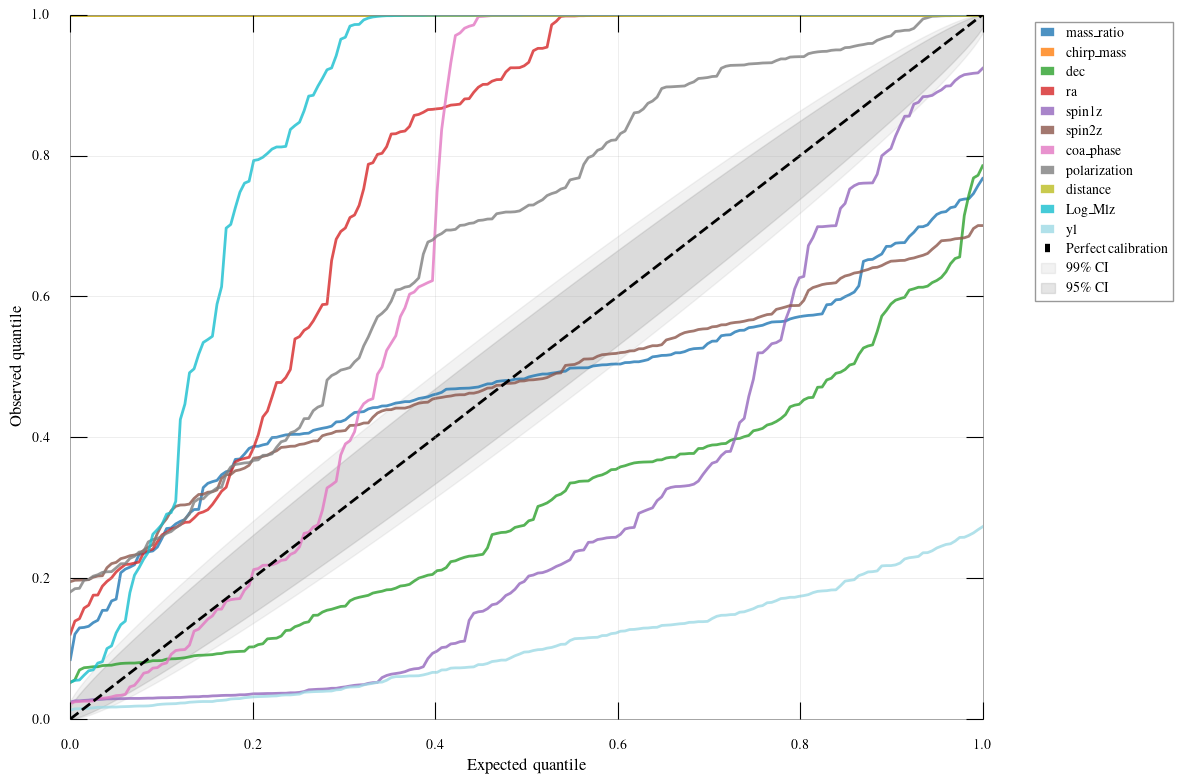

P-P Plot Statistics:

mass_ratio:
  Mean P-value: 0.4720 (should be ~0.5)
  Std P-value: 0.1448 (should be ~0.2887)
  KS test p-value: 0.0000 (>0.05 indicates good calibration)

chirp_mass:
  Mean P-value: 1.0000 (should be ~0.5)
  Std P-value: 0.0000 (should be ~0.2887)
  KS test p-value: 0.0000 (>0.05 indicates good calibration)

dec:
  Mean P-value: 0.2997 (should be ~0.5)
  Std P-value: 0.1827 (should be ~0.2887)
  KS test p-value: 0.0000 (>0.05 indicates good calibration)

ra:
  Mean P-value: 0.7719 (should be ~0.5)
  Std P-value: 0.2981 (should be ~0.2887)
  KS test p-value: 0.0000 (>0.05 indicates good calibration)

spin1z:
  Mean P-value: 0.2953 (should be ~0.5)
  Std P-value: 0.2964 (should be ~0.2887)
  KS test p-value: 0.0000 (>0.05 indicates good calibration)

spin2z:
  Mean P-value: 0.4743 (should be ~0.5)
  Std P-value: 0.1325 (should be ~0.2887)
  KS test p-value: 0.0000 (>0.05 indicates good calibration)

coa_phase:
  Mean P-value: 0.6919 (should be ~0.5)
  Std P-value:

In [ ]:
if __name__ == "__main__":

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # flow.load_state_dict(torch.load('trained_flow_model.pth'))
    
    pp_values, parameter_names = calculate_pp_values(
        flow, test_data_loader, samples[0], device, num_posterior_samples=5000
    )
    

    # print("Generating P-P plots in subplot grid...")
    # fig = plot_pp_plot(pp_values, parameter_names, confidence_level=0.95)
    
    print("Generating overlaid P-P plot...")
    plot_overlay_pp_plot(pp_values, parameter_names, confidence_level=0.95)

    compute_pp_statistics(pp_values, parameter_names)
    
    # np.save('pp_values.npy', pp_values)
    # np.save('parameter_names.npy', parameter_names)
    
    print("\nP-P analysis completed!")

Length of parameters_list: 1000
Using device: cuda


[Epoch 1] Train Loss: 26.0540 | Val Loss: 17.8055


[Epoch 10] Train Loss: 18.7262 | Val Loss: 17.8732


[Epoch 20] Train Loss: 12.6870 | Val Loss: 14.4566


[Epoch 30] Train Loss: 8.2889 | Val Loss: 10.3700


[Epoch 40] Train Loss: 6.3335 | Val Loss: 7.2013


[Epoch 50] Train Loss: 5.4518 | Val Loss: 5.9288


[Epoch 60] Train Loss: 4.2398 | Val Loss: 4.6552


[Epoch 70] Train Loss: 3.8730 | Val Loss: 4.2799


[Epoch 80] Train Loss: 3.5657 | Val Loss: 3.7014


[Epoch 90] Train Loss: 3.5209 | Val Loss: 3.8219


[Epoch 100] Train Loss: 3.4966 | Val Loss: 3.7427


[Epoch 110] Train Loss: 3.1507 | Val Loss: 3.8109


[Epoch 120] Train Loss: 3.4014 | Val Loss: 3.7223


[Epoch 130] Train Loss: 3.1229 | Val Loss: 3.6436


[Epoch 140] Train Loss: 2.7882 | Val Loss: 3.6980


[Epoch 150] Train Loss: 3.2221 | Val Loss: 3.3962


[Epoch 160] Train Loss: 3.1959 | Val Loss: 3.5661


[Epoch 170] Train Loss: 3.6045 | Val Loss: 3.6489


[Epoch 180] Train Loss: 2.9589 | Val Loss: 3.6289


[Epoch 190] Train Loss: 3.1322 | Val Loss: 3.6815


[Epoch 200] Train Loss: 3.2378 | Val Loss: 3.5388


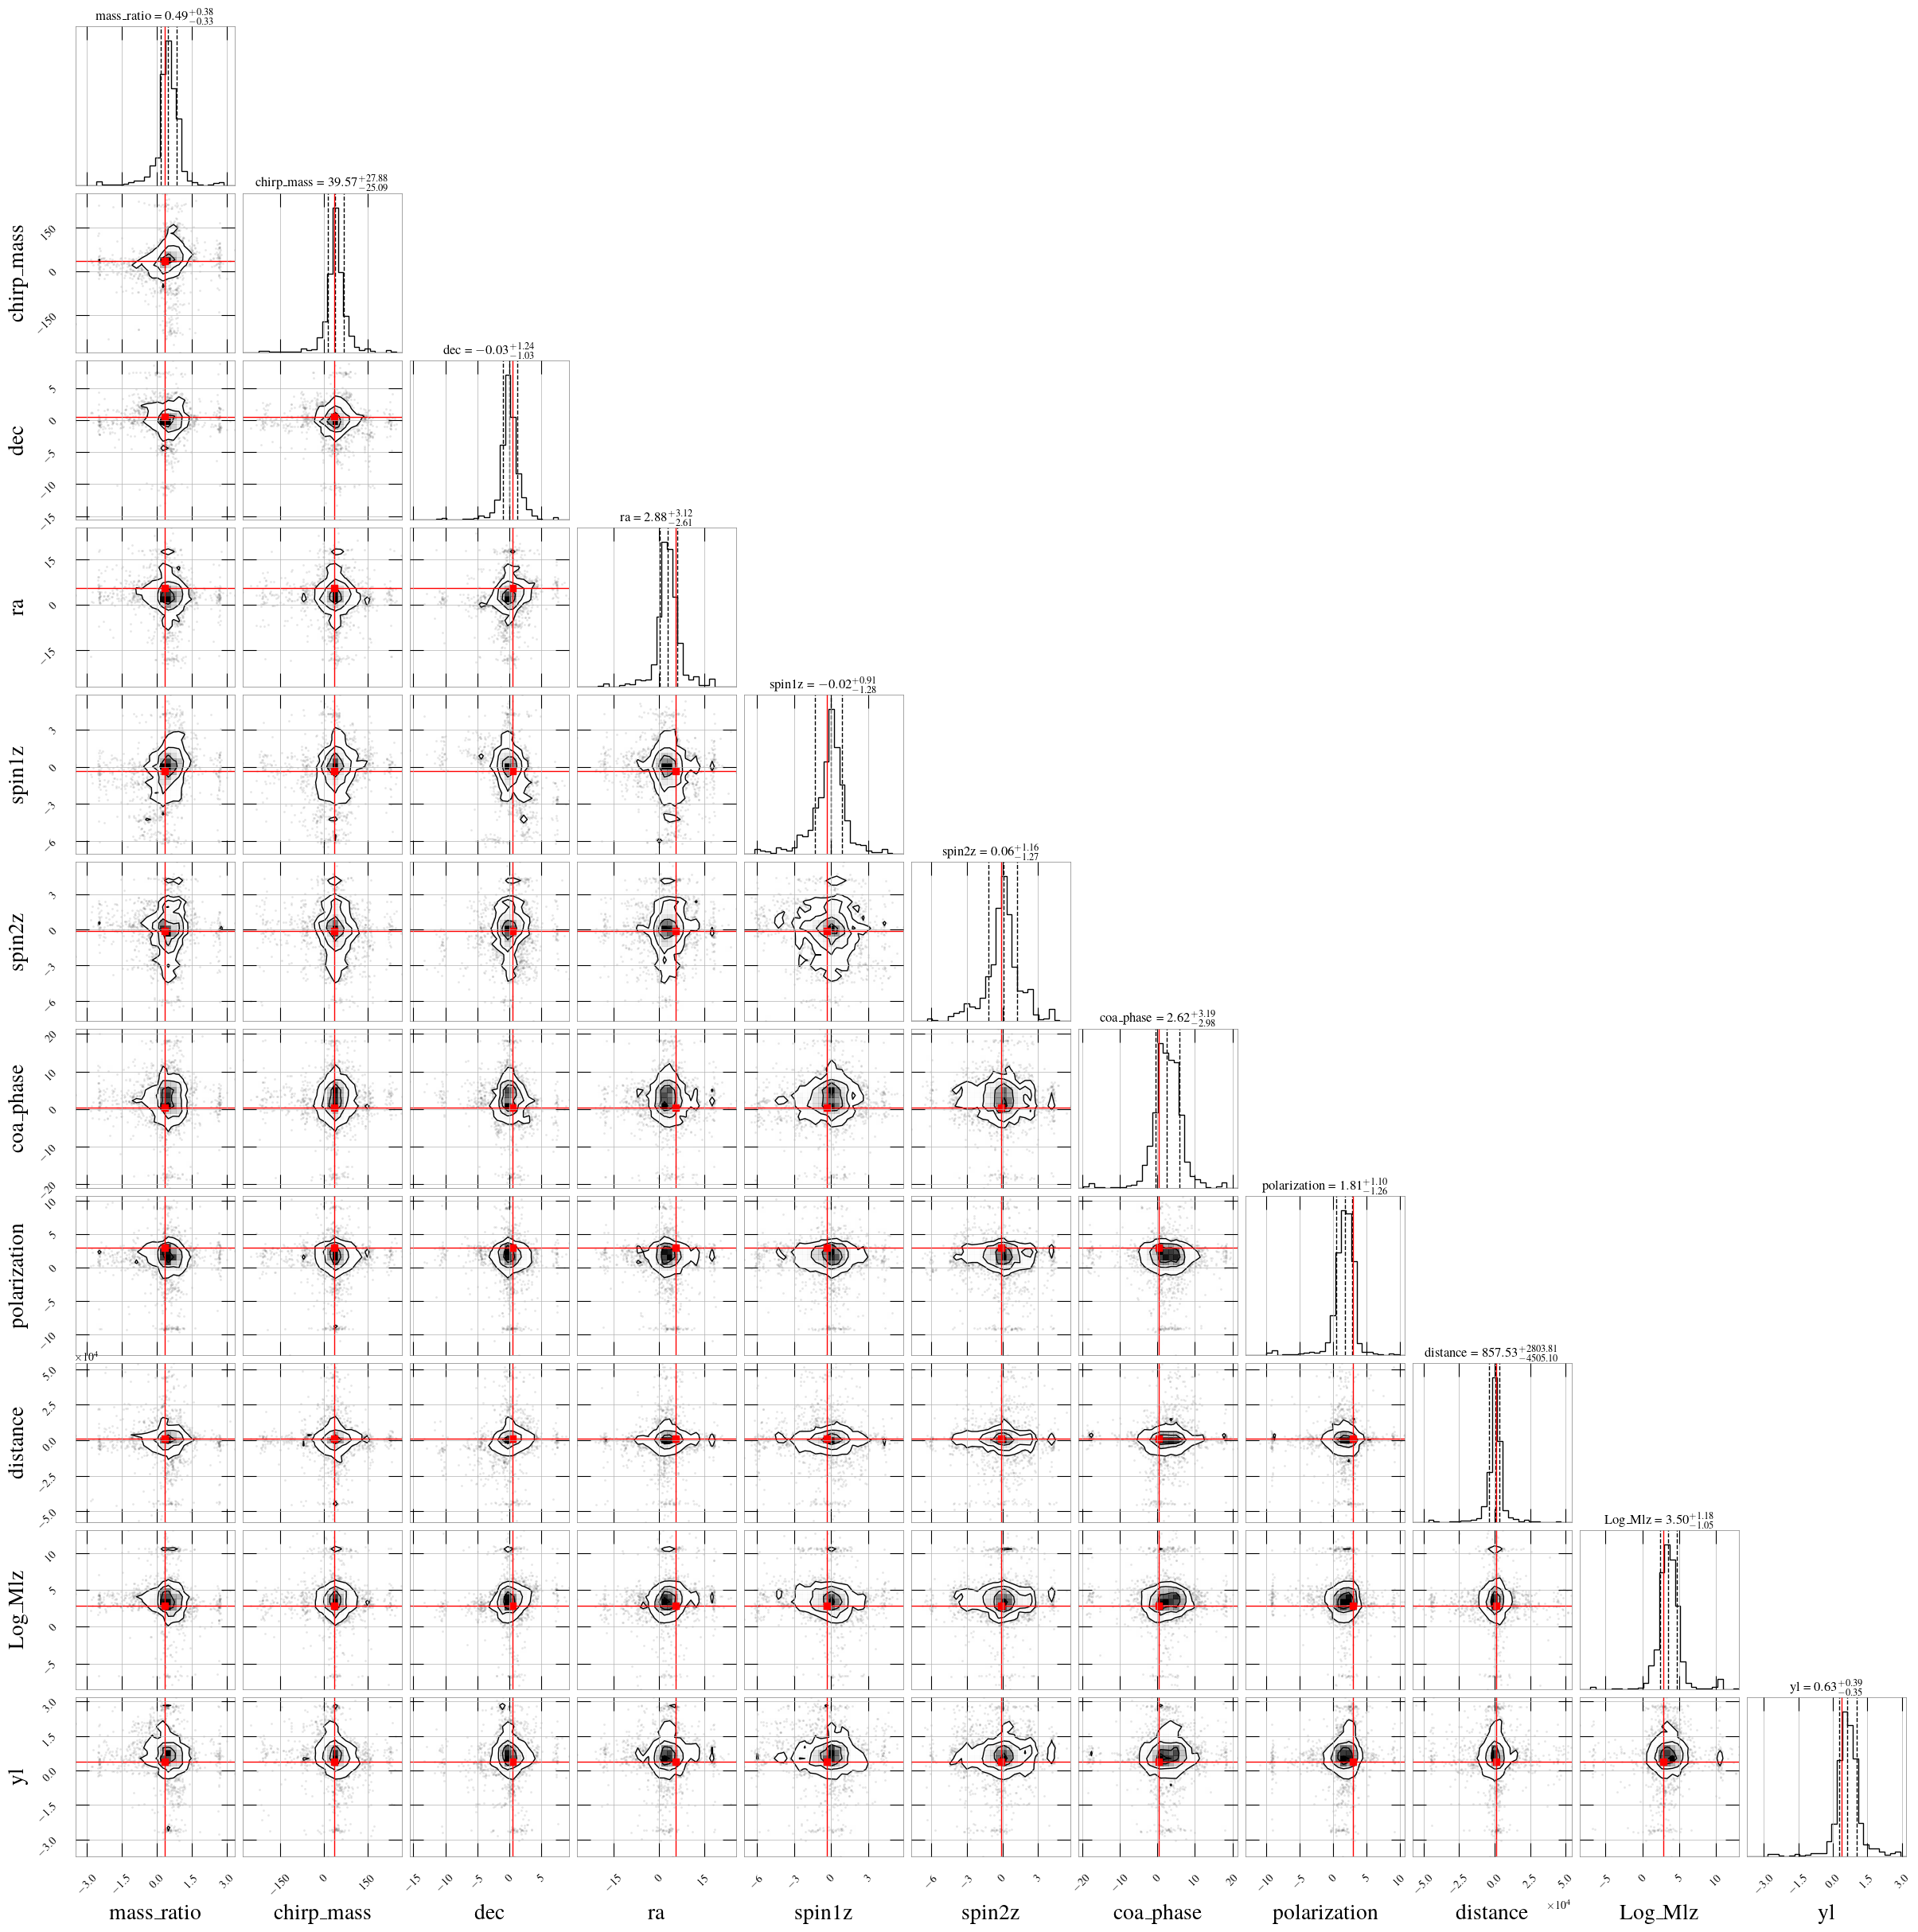

Computing P-P values: 100%|██████████| 150/150 [06:02<00:00,  2.42s/it]

Generating overlaid P-P plot...


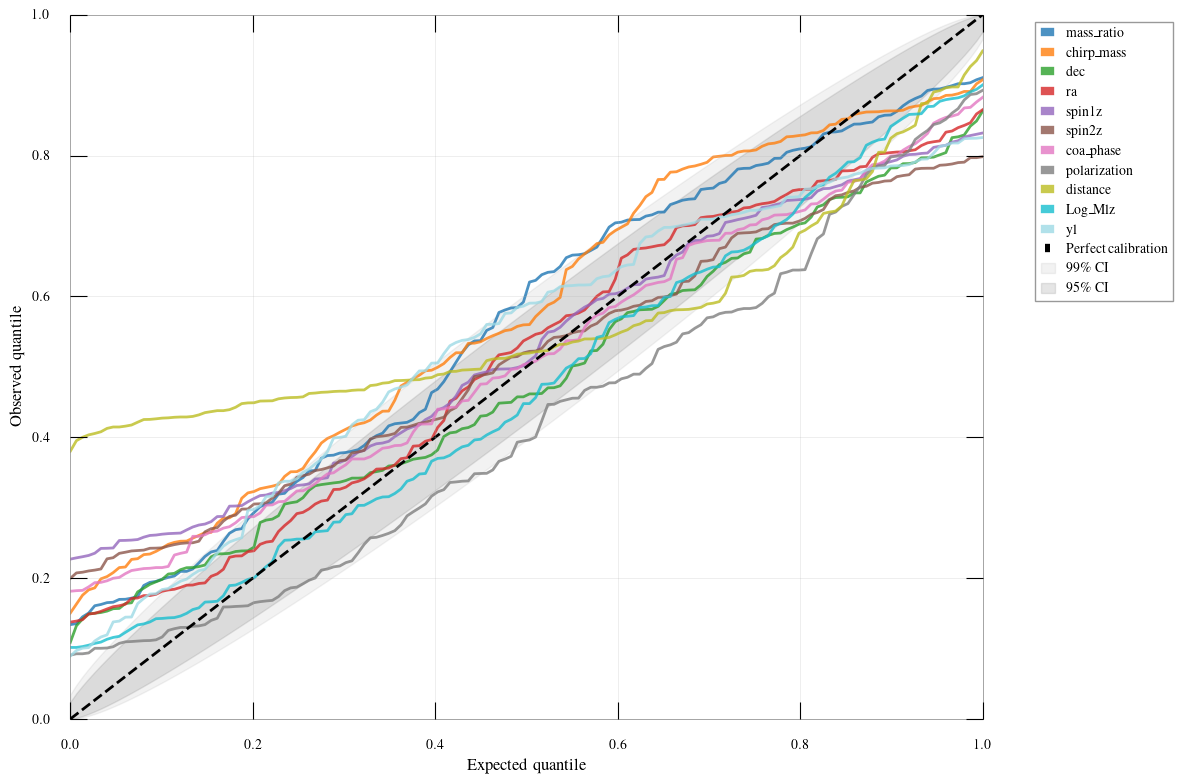

P-P Plot Statistics:

mass_ratio:
  Mean P-value: 0.5584 (should be ~0.5)
  Std P-value: 0.2478 (should be ~0.2887)
  KS test p-value: 0.0082 (>0.05 indicates good calibration)

chirp_mass:
  Mean P-value: 0.5752 (should be ~0.5)
  Std P-value: 0.2371 (should be ~0.2887)
  KS test p-value: 0.0005 (>0.05 indicates good calibration)

dec:
  Mean P-value: 0.4796 (should be ~0.5)
  Std P-value: 0.2130 (should be ~0.2887)
  KS test p-value: 0.0012 (>0.05 indicates good calibration)

ra:
  Mean P-value: 0.5089 (should be ~0.5)
  Std P-value: 0.2348 (should be ~0.2887)
  KS test p-value: 0.0050 (>0.05 indicates good calibration)

spin1z:
  Mean P-value: 0.5243 (should be ~0.5)
  Std P-value: 0.1975 (should be ~0.2887)
  KS test p-value: 0.0000 (>0.05 indicates good calibration)

spin2z:
  Mean P-value: 0.5081 (should be ~0.5)
  Std P-value: 0.1898 (should be ~0.2887)
  KS test p-value: 0.0000 (>0.05 indicates good calibration)

coa_phase:
  Mean P-value: 0.5118 (should be ~0.5)
  Std P-value:

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")


from tqdm import tqdm
import multiprocessing as mp
import bilby
import numpy as np
from pycbc.waveform import get_td_waveform, taper_timeseries
from gwmat import point_lens
import matplotlib.pyplot as plt
import gwmat
import os
import sys
from pycbc.detector.ground import Detector
import pycbc
import bilby
from bilby.gw.prior import BBHPriorDict


import corner
import torch
from torch.utils.data import Dataset, DataLoader


from gwtorch.modules.gw_utils import inject_noise_with_target_SNR


from nflows.flows import Flow
from nflows.distributions import StandardNormal
from nflows.transforms.autoregressive import MaskedPiecewiseRationalQuadraticAutoregressiveTransform
from nflows.transforms import CompositeTransform, RandomPermutation


from modules.pp_plot_code import calculate_pp_values, compute_pp_statistics


from matplotlib import rc
rc('text', usetex=True)
rc('font', family='serif')
rc('font', serif='times')
rc('mathtext', default='sf')
rc("lines", markeredgewidth=1)
rc("lines", linewidth=1)
rc('axes', labelsize=20)
rc("axes", linewidth=0.5)
rc('xtick', labelsize=10)
rc('ytick', labelsize=10)
rc('legend', fontsize=10)
rc('ytick', right=True, direction='in')
rc('xtick', top=True, direction='in')
rc('xtick.major', pad=15)
rc('ytick.major', pad=15)
rc('xtick.major', size=12)
rc('ytick.major', size=12)
rc('xtick.minor', size=7)
rc('ytick.minor', size=7)

import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import rc

def set_tick_sizes(ax, major=12, minor=7):
    for line in ax.xaxis.get_ticklines() + ax.yaxis.get_ticklines():
        line.set_markersize(major)
    for tick in ax.xaxis.get_minor_ticks() + ax.yaxis.get_minor_ticks():
        tick.tick1line.set_markersize(minor)
        tick.tick2line.set_markersize(minor)

def plot_overlay_pp_plot(pp_values, parameter_names, confidence_level=0.95):

    n_tests = pp_values.shape[0]

    # Calculate 95% CI
    alpha = 1 - confidence_level
    alpha_lower_bound = stats.beta.ppf(alpha/2, np.arange(1, n_tests+1), n_tests - np.arange(1, n_tests+1) + 1)
    alpha_upper_bound = stats.beta.ppf(1 - alpha/2, np.arange(1, n_tests+1), n_tests - np.arange(1, n_tests+1) + 1)

    # Calculate 99% CI
    beta = 1 - 0.99
    beta_lower_bound = stats.beta.ppf(beta/2, np.arange(1, n_tests+1), n_tests - np.arange(1, n_tests+1) + 1)
    beta_upper_bound = stats.beta.ppf(1 - beta/2, np.arange(1, n_tests+1), n_tests - np.arange(1, n_tests+1) + 1)

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))
    set_tick_sizes(ax)

    # Expected quantiles
    expected_quantiles = np.linspace(0, 1, n_tests)

    # Colors for different parameters
    colors = plt.cm.tab20(np.linspace(0, 1, len(parameter_names)))

    # Plot each parameter
    for i, param_name in enumerate(parameter_names):
        sorted_pp = np.sort(pp_values[:, i])
        ax.plot(expected_quantiles, sorted_pp, color=colors[i], linewidth=2, 
                label=param_name, alpha=0.8)

    # Perfect calibration line
    ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect calibration')

    # Fill 99% CI first (lighter)
    ax.fill_between(expected_quantiles, beta_lower_bound, beta_upper_bound, 
                    alpha=0.1, color='gray', label='99\% CI')

    # Fill 95% CI on top (darker)
    ax.fill_between(expected_quantiles, alpha_lower_bound, alpha_upper_bound, 
                    alpha=0.2, color='gray', label=f'{confidence_level*100:.0f}\% CI')

    # Labels and styling
    ax.set_xlabel('Expected quantile', fontsize=12)
    ax.set_ylabel('Observed quantile', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

num_samples = 1000
f_lower = 20.0       


priors = BBHPriorDict()


for key in ['a_1', 'a_2', 'tilt_1', 'tilt_2', 'theta_jn', 'phi_12', 'phi_jl', 'luminosity_distance', 'psi', 'phase']:
    priors.pop(key, None)


priors['mass_1'].minimum = 10
priors['mass_2'].minimum = 10
priors['chirp_mass'] = bilby.gw.prior.UniformInComponentsChirpMass(name='chirp_mass', minimum=10, maximum=100)
priors['mass_ratio'] = bilby.gw.prior.UniformInComponentsMassRatio(name='mass_ratio', minimum=0.1, maximum=1)
priors['spin1z'] = bilby.core.prior.Uniform(name='spin1z', minimum=-0.9, maximum=0.9)
priors['spin2z'] = bilby.core.prior.Uniform(name='spin2z', minimum=-0.9, maximum=0.9)
priors['coa_phase'] = bilby.core.prior.Uniform(name='coa_phase', minimum=0.0, maximum=2 * np.pi)
priors['polarization'] = bilby.core.prior.Uniform(minimum=0., maximum=np.pi, boundary="periodic")
priors['Log_Mlz'] = bilby.core.prior.Uniform(minimum=2, maximum=5)
priors['yl'] = bilby.core.prior.PowerLaw(alpha=1, minimum=0.01, maximum=1.0)


parameters_list = priors.sample(num_samples)


samples = [
    {key: parameters_list[key][i] for key in parameters_list}
    for i in range(num_samples)
]


print(f"Length of parameters_list: {len(samples)}")


def waveform(num):
    parameters = samples[num].copy()


    # Convert masses
    mass1, mass2 = bilby.gw.conversion.chirp_mass_and_mass_ratio_to_component_masses(
        parameters['chirp_mass'], parameters['mass_ratio']
    )


    m_lens = np.power(10., parameters.pop("Log_Mlz"))
    y_lens = parameters.pop("yl")


    # Generate unlensed waveform
    sp, sc = get_td_waveform(
        approximant='SEOBNRv4_opt',
        mass1=mass1,
        mass2=mass2,
        spin1z=parameters['spin1z'],
        spin2z=parameters['spin2z'],
        distance=300,
        delta_t=1.0 / 4096,
        coa_phase=parameters['coa_phase'],
        f_lower=f_lower,
    )


    # Frequency-domain lensing
    sp_freq = sp.to_frequencyseries(delta_f=sp.delta_f)
    sc_freq = sc.to_frequencyseries(delta_f=sc.delta_f)
    fs1 = sp_freq.sample_frequencies


    Ffs = [gwmat.cythonized_point_lens.Ff_effective(f, ml=m_lens, y=y_lens) for f in fs1]
    time_Delay = point_lens.time_delay(ml=m_lens, y=y_lens)


    sp_lensed = pycbc.types.FrequencySeries(np.conj(Ffs) * np.asarray(sp_freq),
                                            delta_f=sp_freq.delta_f).cyclic_time_shift(-1 * (0.1 + time_Delay))
    sc_lensed = pycbc.types.FrequencySeries(np.conj(Ffs) * np.asarray(sc_freq),
                                            delta_f=sc_freq.delta_f).cyclic_time_shift(-1 * (0.1 + time_Delay))


    sp_lensed = sp_lensed.to_timeseries(delta_t=sp_lensed.delta_t)
    sc_lensed = sc_lensed.to_timeseries(delta_t=sc_lensed.delta_t)


    # Detector projection
    detector = Detector('H1')
    lensed_signal = detector.project_wave(
        sp_lensed, sc_lensed,
        ra=parameters['ra'], dec=parameters['dec'], polarization=parameters['polarization']
    )
    lensed_signal = taper_timeseries(lensed_signal, tapermethod="TAPER_STARTEND", return_lal=False)


    # Inject noise with target SNR
    target_snr = np.random.randint(15, 100)
    lensed_noisy, _, distance, _ = inject_noise_with_target_SNR(
        lensed_signal, parameters, mass1, mass2, m_lens, y_lens,
        target_snr, num, gw_signal_type='lensed',
        peak_window=(2.0, 2.2), detector=detector
    )


    # Update local copy of parameters
    parameters['distance'] = distance
    parameters['Log_Mlz'] = np.log10(m_lens)
    parameters['yl'] = y_lens


    lensed_noisy = lensed_noisy.crop(left=24, right=0)


    return np.array(lensed_noisy), parameters



def simulator(num):
    waveform_array, updated_params = waveform(num)
    return updated_params, waveform_array


def simulate_one(ii):
    theta_val, y_val = simulator(ii)
    return theta_val, y_val



num_simulations = num_samples


if __name__ == "__main__":
    with mp.Pool(processes=mp.cpu_count(), maxtasksperchild=500) as pool:
        results = pool.map(simulate_one, range(num_simulations))


    # Unzip results
    updated_samples, data_vals = zip(*results)
    updated_samples = list(updated_samples)
    data_vals = list(data_vals)


    # Replace old samples with updated ones
    samples = updated_samples


    theta_vals, data_vals = zip(*results)


    theta_vals = [list(d.values()) for d in theta_vals]

    # --- Begin normalization code ---

    # Extract parameter names
    param_names = list(samples[0].keys())

    # Convert to numpy array
    theta_array = np.array(theta_vals)

    # Compute min and max per parameter for normalization
    param_min = theta_array.min(axis=0)
    param_max = theta_array.max(axis=0)

    # Define normalization function
    def normalize_params(params):
        return (params - param_min) / (param_max - param_min)

    # Define denormalization function
    def denormalize_params(norm_params):
        return norm_params * (param_max - param_min) + param_min

    # Normalize theta parameters
    theta_vals_norm = normalize_params(theta_array)

    # Convert normalized parameters and data to torch tensors
    theta_vals = torch.from_numpy(theta_vals_norm).to(torch.float32)
    data_vals = torch.from_numpy(np.array(data_vals)).to(torch.float32)

    # --- End normalization code ---


    # create dataset
    class DataGenerator(Dataset):
        def __len__(self):
            return num_simulations


        def __getitem__(self, idx):
            if torch.is_tensor(idx):
                idx = idx.tolist()


            return theta_vals[idx], data_vals[idx]


    dataset = DataGenerator()


    # create dataloaders - 80/10/10 split
    train_set_size = int(0.8 * num_simulations)
    val_set_size = int(0.05 * num_simulations)
    test_set_size = int(0.15 * num_simulations)


    train_data, val_data, test_data = torch.utils.data.random_split(
        dataset, [train_set_size, val_set_size, test_set_size])


    train_data_loader = DataLoader(
        train_data, batch_size=256,
        shuffle=True
    )


    val_data_loader = DataLoader(
        val_data, batch_size=256,
        shuffle=True
    )


    test_data_loader = DataLoader(
        test_data, batch_size=1,
        shuffle=False
    )


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")


    num_transforms = 24
    num_blocks = 24
    hidden_features = 50


    context_features = data_vals[0].shape[0]
    parameter_space_dim = len(samples[0].keys())


    base_dist = StandardNormal([parameter_space_dim])  


    transforms = []


    for _ in range(num_transforms):
        block = [
            MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
                    features=parameter_space_dim, 
                    hidden_features=hidden_features,
                    context_features=context_features,
                    num_blocks=num_blocks,
                    activation=torch.tanh,
                    use_batch_norm=True,
                    use_residual_blocks=False,
                    tails='linear',
                    tail_bound=1.0,
                    num_bins=8
            ),
            RandomPermutation(features=parameter_space_dim)
        ]
        transforms += block


    transform = CompositeTransform(transforms)


    flow = Flow(transform, base_dist).to(device)


    optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)


    for i in range(200):
        flow.train()
        train_loss_total = 0.0


        train_loader = tqdm(train_data_loader, desc=f"Epoch {i+1} [Train]", leave=False)
        for idx, val in enumerate(train_loader):
            theta, data = val
            theta = theta.to(device)
            data = data.to(device)


            optimizer.zero_grad()
            loss = -flow.log_prob(theta, context=data).mean()
            loss.backward()
            optimizer.step()
            
            train_loss_total += loss.item()
            train_loader.set_postfix(loss=loss.item())


        scheduler.step()
        train_loss_avg = train_loss_total / len(train_data_loader)


        flow.eval()
        val_loss_total = 0.0
        with torch.no_grad():
            val_loader = tqdm(val_data_loader, desc=f"Epoch {i+1} [Val]", leave=False)
            for idx, val in enumerate(val_loader):
                theta, data = val
                theta = theta.to(device)
                data = data.to(device)


                val_loss_batch = -flow.log_prob(theta, context=data).mean()
                val_loss_total += val_loss_batch.item()
                val_loader.set_postfix(loss=val_loss_batch.item())


        val_loss_avg = val_loss_total / len(val_data_loader)


        if i == 0 or (i+1) % 10 == 0:
            print(f"[Epoch {i+1}] Train Loss: {train_loss_avg:.4f} | Val Loss: {val_loss_avg:.4f}")


    torch.save(flow.state_dict(), "flow_bbh.pth")


    theta_test, data_test = next(iter(test_data_loader))
    theta_test = theta_test.to(device)
    data_test = data_test.to(device)
    with torch.no_grad():
            posterior_samples = flow.sample(5000, context=data_test.reshape(tuple(data_test.shape)))


    theta_test = theta_test.squeeze(0)

    # Denormalize posterior samples back to original parameter scales
    posterior_samples_np = posterior_samples.squeeze(0).cpu().numpy()
    posterior_samples_denorm = denormalize_params(posterior_samples_np)

    data = posterior_samples_denorm


    figure = corner.corner(
        data,
        bins=30,  # Number of bins
        labels=param_names,
        quantiles=[0.16, 0.5, 0.84], 
        show_titles=True,
        title_kwargs={"fontsize": 12},
        truths=denormalize_params(theta_test.cpu().numpy()),
        truth_color="red",
    )

    def set_tick_sizes_corner(fig, major=12, minor=7):
        for ax in fig.get_axes():
            for line in ax.xaxis.get_ticklines() + ax.yaxis.get_ticklines():
                line.set_markersize(major)
            for tick in ax.xaxis.get_minor_ticks() + ax.yaxis.get_minor_ticks():
                tick.tick1line.set_markersize(minor)
                tick.tick2line.set_markersize(minor)


    set_tick_sizes_corner(figure)

    plt.show()


    # flow.load_state_dict(torch.load('trained_flow_model.pth'))


    pp_values, parameter_names = calculate_pp_values(
        flow, test_data_loader, samples[0], device, num_posterior_samples=5000
    )


    print("Generating overlaid P-P plot...")
    plot_overlay_pp_plot(pp_values, parameter_names, confidence_level=0.95)


    compute_pp_statistics(pp_values, parameter_names)


    # np.save('pp_values.npy', pp_values)
    # np.save('parameter_names.npy', parameter_names)


    print("\nP-P analysis completed!")


Length of parameters_list: 3000
Using device: cuda


[Epoch 1] Train Loss: 25.3566 | Val Loss: 21.8138


[Epoch 10] Train Loss: 8.0743 | Val Loss: 11.6332


[Epoch 20] Train Loss: 2.9809 | Val Loss: 4.7948


[Epoch 30] Train Loss: 1.1789 | Val Loss: 2.7107


[Epoch 40] Train Loss: 0.2334 | Val Loss: 1.5989


[Epoch 50] Train Loss: -0.2033 | Val Loss: 0.9851


[Epoch 60] Train Loss: -0.4572 | Val Loss: 0.2133


[Epoch 70] Train Loss: -0.5740 | Val Loss: 0.3960


[Epoch 80] Train Loss: -0.7200 | Val Loss: 0.0878


[Epoch 90] Train Loss: -0.7443 | Val Loss: -0.0255


[Epoch 100] Train Loss: -0.8309 | Val Loss: 0.0489


[Epoch 110] Train Loss: -0.9128 | Val Loss: 0.0495


[Epoch 120] Train Loss: -0.8642 | Val Loss: 0.1632


[Epoch 130] Train Loss: -0.8679 | Val Loss: 0.0254


[Epoch 140] Train Loss: -0.9730 | Val Loss: 0.0295


[Epoch 150] Train Loss: -0.8954 | Val Loss: 0.0423


[Epoch 160] Train Loss: -0.9124 | Val Loss: 0.0039


[Epoch 170] Train Loss: -0.9861 | Val Loss: 0.0017


[Epoch 180] Train Loss: -0.8969 | Val Loss: 0.0093


[Epoch 190] Train Loss: -0.8931 | Val Loss: 0.0438


[Epoch 200] Train Loss: -0.9747 | Val Loss: 0.0212


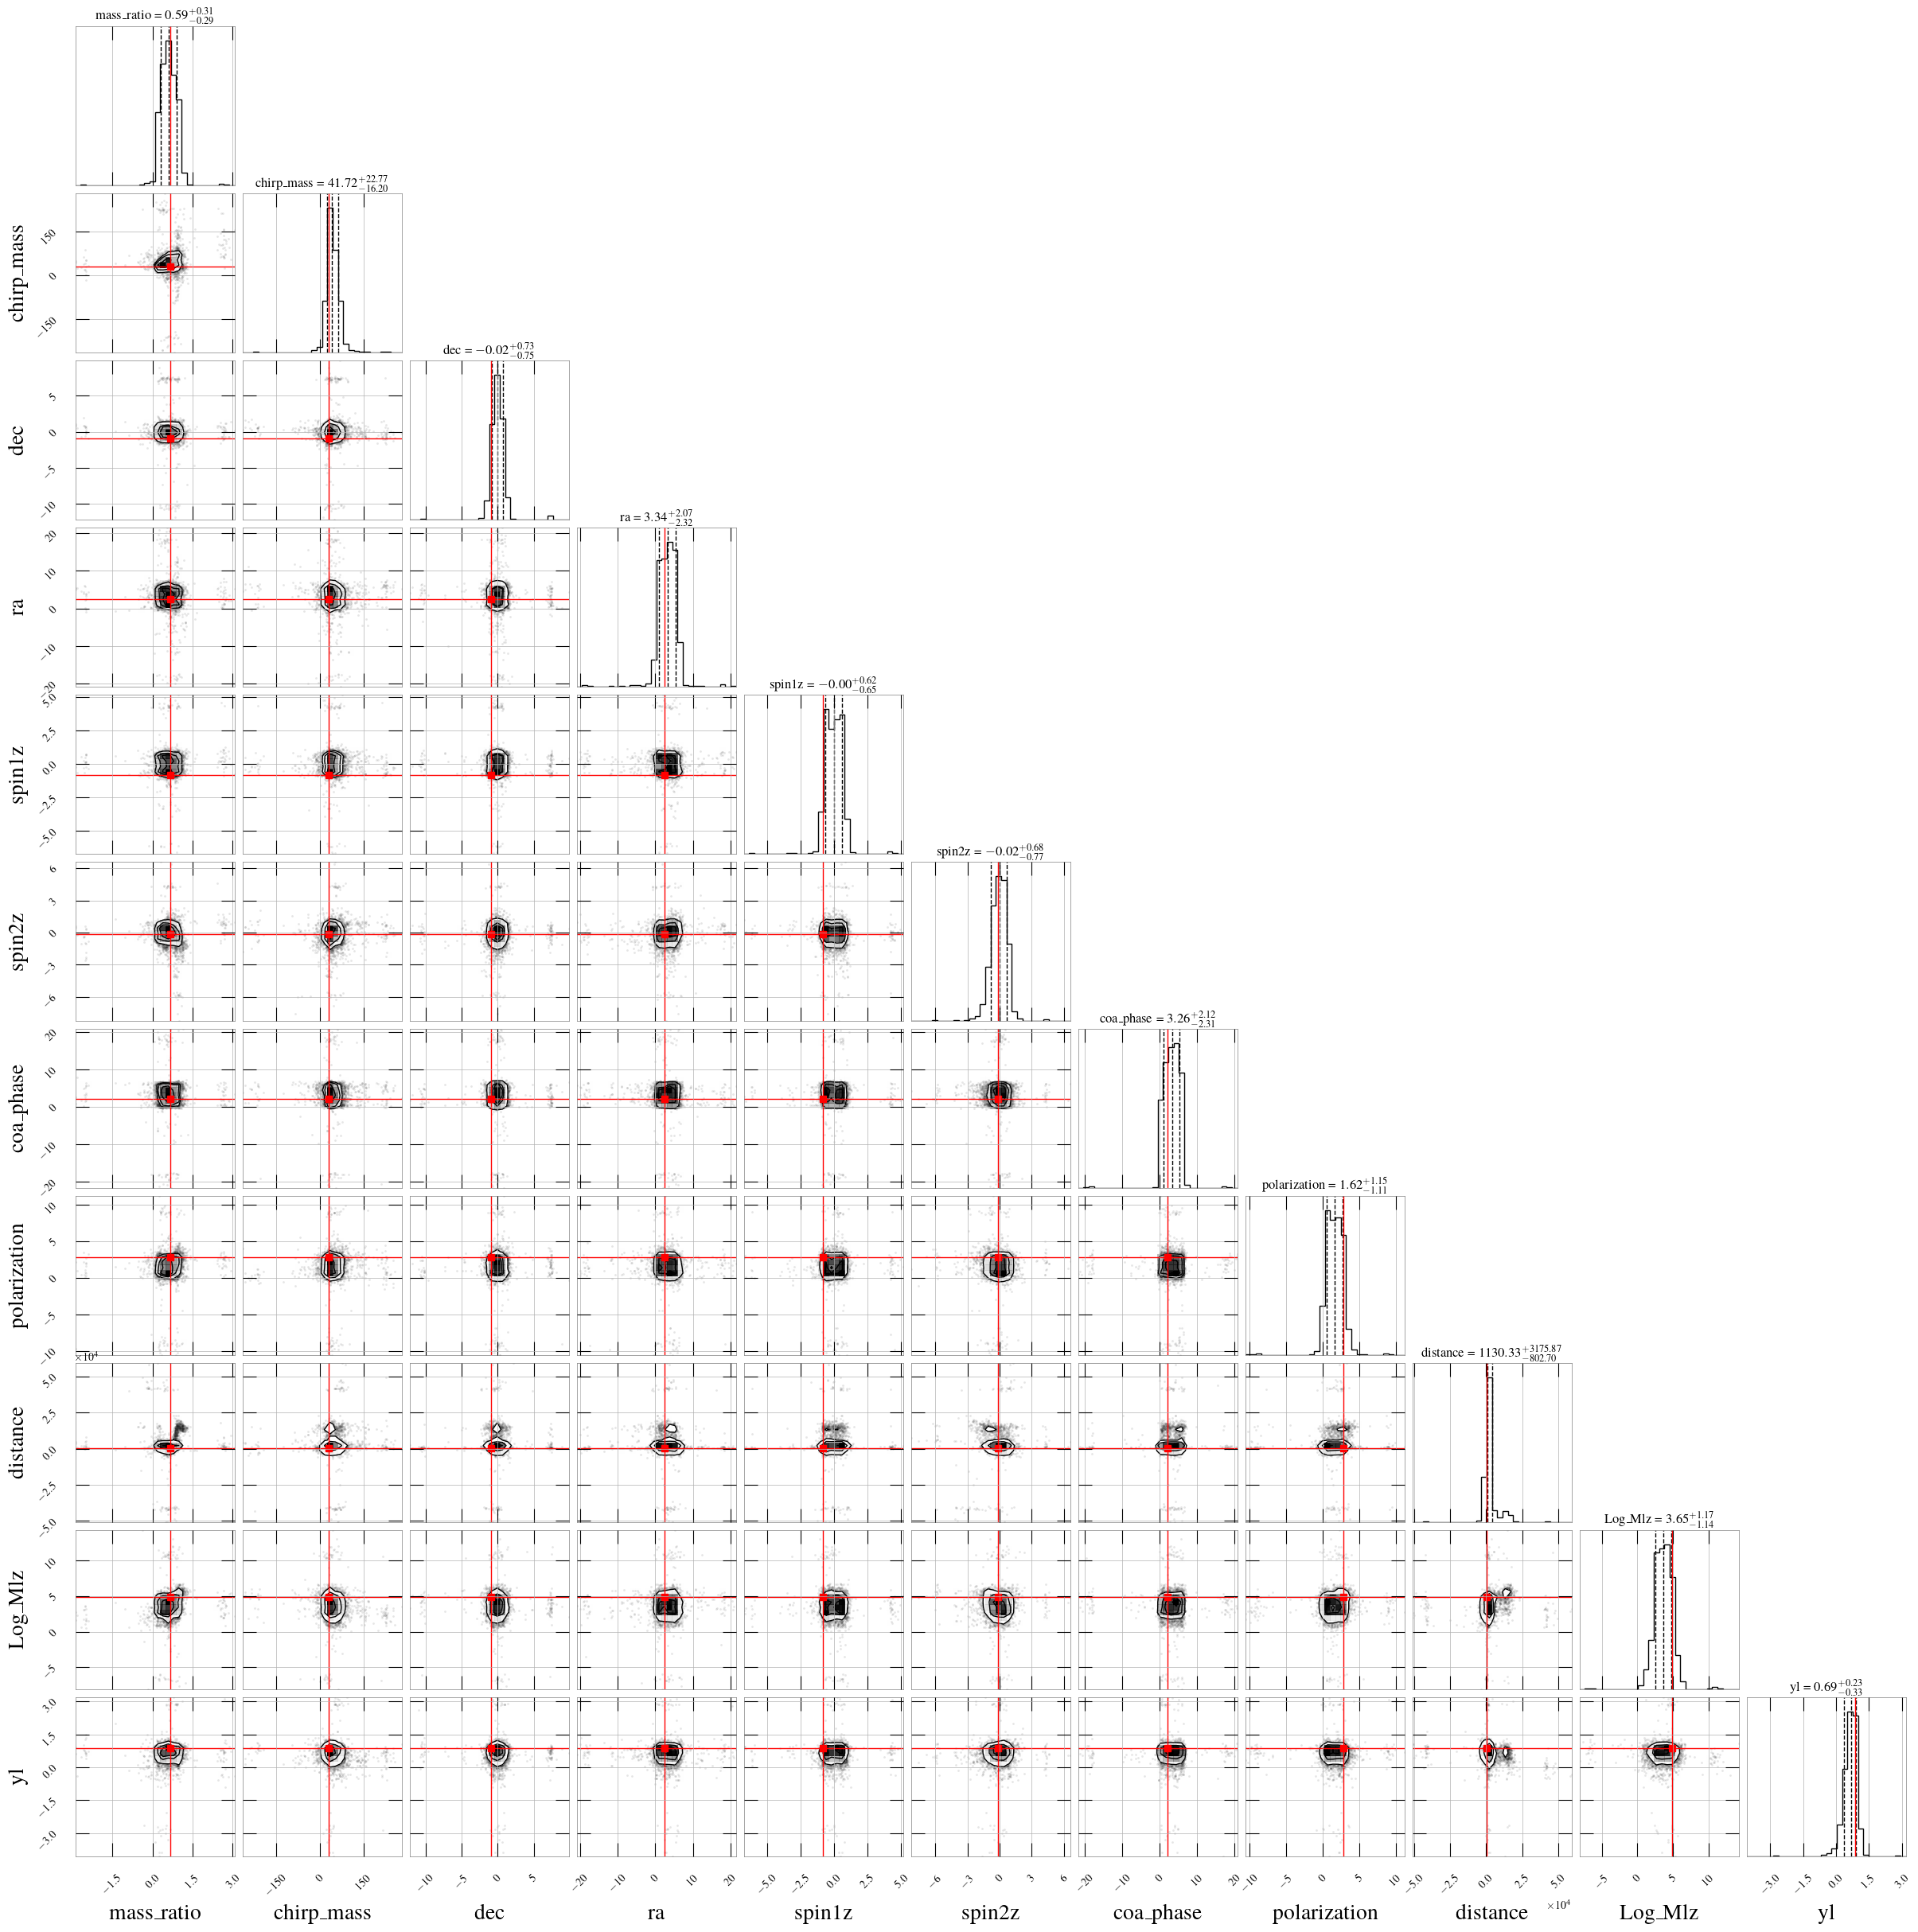

Computing P-P values: 100%|██████████| 450/450 [18:09<00:00,  2.42s/it]

Generating overlaid P-P plot...


NameError: name 'plot_overlay_pp_plot' is not defined

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")


from tqdm import tqdm
import multiprocessing as mp
import bilby
import numpy as np
from pycbc.waveform import get_td_waveform, taper_timeseries
from gwmat import point_lens
import matplotlib.pyplot as plt
import gwmat
import os
import sys
from pycbc.detector.ground import Detector
import pycbc
import bilby
from bilby.gw.prior import BBHPriorDict


import corner
import torch
from torch.utils.data import Dataset, DataLoader


from gwtorch.modules.gw_utils import inject_noise_with_target_SNR


from nflows.flows import Flow
from nflows.distributions import StandardNormal
from nflows.transforms.autoregressive import MaskedPiecewiseRationalQuadraticAutoregressiveTransform
from nflows.transforms import CompositeTransform, RandomPermutation


from modules.pp_plot_code import calculate_pp_values, compute_pp_statistics


from matplotlib import rc
rc('text', usetex=True)
rc('font', family='serif')
rc('font', serif='times')
rc('mathtext', default='sf')
rc("lines", markeredgewidth=1)
rc("lines", linewidth=1)
rc('axes', labelsize=20)
rc("axes", linewidth=0.5)
rc('xtick', labelsize=10)
rc('ytick', labelsize=10)
rc('legend', fontsize=10)
rc('ytick', right=True, direction='in')
rc('xtick', top=True, direction='in')
rc('xtick.major', pad=15)
rc('ytick.major', pad=15)
rc('xtick.major', size=12)
rc('ytick.major', size=12)
rc('xtick.minor', size=7)
rc('ytick.minor', size=7)


def set_tick_sizes(ax, major=12, minor=7):
    for line in ax.xaxis.get_ticklines() + ax.yaxis.get_ticklines():
        line.set_markersize(major)
    for tick in ax.xaxis.get_minor_ticks() + ax.yaxis.get_minor_ticks():
        tick.tick1line.set_markersize(minor)
        tick.tick2line.set_markersize(minor)


num_samples = 3000
f_lower = 20.0


priors = BBHPriorDict()


for key in ['a_1', 'a_2', 'tilt_1', 'tilt_2', 'theta_jn', 'phi_12', 'phi_jl', 'luminosity_distance', 'psi', 'phase']:
    priors.pop(key, None)


priors['mass_1'].minimum = 10
priors['mass_2'].minimum = 10
priors['chirp_mass'] = bilby.gw.prior.UniformInComponentsChirpMass(name='chirp_mass', minimum=10, maximum=100)
priors['mass_ratio'] = bilby.gw.prior.UniformInComponentsMassRatio(name='mass_ratio', minimum=0.1, maximum=1)
priors['spin1z'] = bilby.core.prior.Uniform(name='spin1z', minimum=-0.9, maximum=0.9)
priors['spin2z'] = bilby.core.prior.Uniform(name='spin2z', minimum=-0.9, maximum=0.9)
priors['coa_phase'] = bilby.core.prior.Uniform(name='coa_phase', minimum=0.0, maximum=2 * np.pi)
priors['polarization'] = bilby.core.prior.Uniform(minimum=0., maximum=np.pi, boundary="periodic")
priors['Log_Mlz'] = bilby.core.prior.Uniform(minimum=2, maximum=5)
priors['yl'] = bilby.core.prior.PowerLaw(alpha=1, minimum=0.01, maximum=1.0)


parameters_list = priors.sample(num_samples)


samples = [
    {key: parameters_list[key][i] for key in parameters_list}
    for i in range(num_samples)
]


print(f"Length of parameters_list: {len(samples)}")


def waveform(num):
    parameters = samples[num].copy()

    # Convert masses
    mass1, mass2 = bilby.gw.conversion.chirp_mass_and_mass_ratio_to_component_masses(
        parameters['chirp_mass'], parameters['mass_ratio']
    )

    m_lens = np.power(10., parameters.pop("Log_Mlz"))
    y_lens = parameters.pop("yl")

    # Generate unlensed waveform
    sp, sc = get_td_waveform(
        approximant='SEOBNRv4_opt',
        mass1=mass1,
        mass2=mass2,
        spin1z=parameters['spin1z'],
        spin2z=parameters['spin2z'],
        distance=300,
        delta_t=1.0 / 4096,
        coa_phase=parameters['coa_phase'],
        f_lower=f_lower,
    )

    # Frequency-domain lensing
    sp_freq = sp.to_frequencyseries(delta_f=sp.delta_f)
    sc_freq = sc.to_frequencyseries(delta_f=sc.delta_f)
    fs1 = sp_freq.sample_frequencies

    Ffs = [gwmat.cythonized_point_lens.Ff_effective(f, ml=m_lens, y=y_lens) for f in fs1]
    time_Delay = point_lens.time_delay(ml=m_lens, y=y_lens)

    sp_lensed = pycbc.types.FrequencySeries(np.conj(Ffs) * np.asarray(sp_freq),
                                            delta_f=sp_freq.delta_f).cyclic_time_shift(-1 * (0.1 + time_Delay))
    sc_lensed = pycbc.types.FrequencySeries(np.conj(Ffs) * np.asarray(sc_freq),
                                            delta_f=sc_freq.delta_f).cyclic_time_shift(-1 * (0.1 + time_Delay))

    sp_lensed = sp_lensed.to_timeseries(delta_t=sp_lensed.delta_t)
    sc_lensed = sc_lensed.to_timeseries(delta_t=sc_lensed.delta_t)

    # Detector projection
    detector = Detector('H1')
    lensed_signal = detector.project_wave(
        sp_lensed, sc_lensed,
        ra=parameters['ra'], dec=parameters['dec'], polarization=parameters['polarization']
    )
    lensed_signal = taper_timeseries(lensed_signal, tapermethod="TAPER_STARTEND", return_lal=False)

    # Inject noise with target SNR
    target_snr = np.random.randint(15, 100)
    lensed_noisy, _, distance, _ = inject_noise_with_target_SNR(
        lensed_signal, parameters, mass1, mass2, m_lens, y_lens,
        target_snr, num, gw_signal_type='lensed',
        peak_window=(2.0, 2.2), detector=detector
    )

    # Update local copy of parameters
    parameters['distance'] = distance
    parameters['Log_Mlz'] = np.log10(m_lens)
    parameters['yl'] = y_lens

    lensed_noisy = lensed_noisy.crop(left=24, right=0)

    return np.array(lensed_noisy), parameters


def simulator(num):
    waveform_array, updated_params = waveform(num)
    return updated_params, waveform_array


def simulate_one(ii):
    theta_val, y_val = simulator(ii)
    return theta_val, y_val


num_simulations = num_samples


if __name__ == "__main__":
    with mp.Pool(processes=mp.cpu_count(), maxtasksperchild=500) as pool:
        results = pool.map(simulate_one, range(num_simulations))

    # Unzip results
    updated_samples, data_vals = zip(*results)
    updated_samples = list(updated_samples)
    data_vals = list(data_vals)

    # Consistent parameter names ordering
    param_names = list(updated_samples[0].keys())

    # Convert parameters to numpy arrays with consistent ordering
    theta_array = np.array([[sample[name] for name in param_names] for sample in updated_samples])
    data_array = np.array(data_vals)

    # Compute min and max per parameter across all samples
    param_min = theta_array.min(axis=0)
    param_max = theta_array.max(axis=0)

    # Normalize parameters function
    def normalize_params(params):
        return (params - param_min) / (param_max - param_min)

    # Denormalize parameters function
    def denormalize_params(norm_params):
        return norm_params * (param_max - param_min) + param_min

    # Normalize before training
    theta_vals_norm = normalize_params(theta_array)

    # Convert to torch tensor
    theta_vals = torch.from_numpy(theta_vals_norm.astype(np.float32))
    data_vals = torch.from_numpy(data_array.astype(np.float32))

    # Dataset class
    class DataGenerator(Dataset):
        def __len__(self):
            return len(theta_vals)

        def __getitem__(self, idx):
            return theta_vals[idx], data_vals[idx]

    dataset = DataGenerator()

    # Train/val/test split
    train_size = int(0.8 * len(dataset))
    val_size = int(0.05 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    train_data, val_data, test_data = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

    train_data_loader = DataLoader(train_data, batch_size=256, shuffle=True)
    val_data_loader = DataLoader(val_data, batch_size=256, shuffle=True)
    test_data_loader = DataLoader(test_data, batch_size=1, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    num_transforms = 24
    num_blocks = 24
    hidden_features = 50

    context_features = data_vals.shape[1]
    parameter_space_dim = len(param_names)

    base_dist = StandardNormal([parameter_space_dim])

    transforms = []

    for _ in range(num_transforms):
        block = [
            MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
                features=parameter_space_dim,
                hidden_features=hidden_features,
                context_features=context_features,
                num_blocks=num_blocks,
                activation=torch.tanh,
                use_batch_norm=True,
                use_residual_blocks=False,
                tails='linear',
                tail_bound=3.0,
                num_bins=8
            ),
            RandomPermutation(features=parameter_space_dim)
        ]
        transforms += block

    transform = CompositeTransform(transforms)

    flow = Flow(transform, base_dist).to(device)

    optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

    # Training loop
    for i in range(200):
        flow.train()
        train_loss_total = 0.0

        train_loader = tqdm(train_data_loader, desc=f"Epoch {i + 1} [Train]", leave=False)
        for idx, val in enumerate(train_loader):
            theta, data = val
            theta = theta.to(device)
            data = data.to(device)

            optimizer.zero_grad()
            loss = -flow.log_prob(theta, context=data).mean()
            loss.backward()
            optimizer.step()

            train_loss_total += loss.item()
            train_loader.set_postfix(loss=loss.item())

        scheduler.step()
        train_loss_avg = train_loss_total / len(train_data_loader)

        flow.eval()
        val_loss_total = 0.0
        with torch.no_grad():
            val_loader = tqdm(val_data_loader, desc=f"Epoch {i + 1} [Val]", leave=False)
            for idx, val in enumerate(val_loader):
                theta, data = val
                theta = theta.to(device)
                data = data.to(device)

                val_loss_batch = -flow.log_prob(theta, context=data).mean()
                val_loss_total += val_loss_batch.item()
                val_loader.set_postfix(loss=val_loss_batch.item())

        val_loss_avg = val_loss_total / len(val_data_loader)

        if i == 0 or (i + 1) % 10 == 0:
            print(f"[Epoch {i + 1}] Train Loss: {train_loss_avg:.4f} | Val Loss: {val_loss_avg:.4f}")

    torch.save(flow.state_dict(), "flow_bbh.pth")

    # Evaluation and sampling
    theta_test, data_test = next(iter(test_data_loader))
    theta_test = theta_test.to(device)
    data_test = data_test.to(device)
    with torch.no_grad():
        posterior_samples = flow.sample(5000, context=data_test.reshape(tuple(data_test.shape)))

    # Denormalize posterior samples and true parameters for plotting
    posterior_samples_np = posterior_samples.squeeze(0).cpu().numpy()
    posterior_samples_denorm = denormalize_params(posterior_samples_np)
    theta_test_denorm = denormalize_params(theta_test.squeeze(0).cpu().numpy())

    figure = corner.corner(
        posterior_samples_denorm,
        bins=30,
        labels=param_names,
        quantiles=[0.16, 0.5, 0.84],
        show_titles=True,
        title_kwargs={"fontsize": 12},
        truths=theta_test_denorm,
        truth_color="red",
    )

    def set_tick_sizes_corner(fig, major=12, minor=7):
        for ax in fig.get_axes():
            for line in ax.xaxis.get_ticklines() + ax.yaxis.get_ticklines():
                line.set_markersize(major)
            for tick in ax.xaxis.get_minor_ticks() + ax.yaxis.get_minor_ticks():
                tick.tick1line.set_markersize(minor)
                tick.tick2line.set_markersize(minor)

    set_tick_sizes_corner(figure)

    plt.show()

    # P-P plot calculation and presentation
    pp_values, parameter_names = calculate_pp_values(
        flow, test_data_loader, updated_samples[0], device, num_posterior_samples=5000
    )

    print("Generating overlaid P-P plot...")
    plot_overlay_pp_plot(pp_values, parameter_names, confidence_level=0.95)

    compute_pp_statistics(pp_values, parameter_names)

    print("\nP-P analysis completed!")


In [46]:
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import rc

def set_tick_sizes(ax, major=12, minor=7):
    for line in ax.xaxis.get_ticklines() + ax.yaxis.get_ticklines():
        line.set_markersize(major)
    for tick in ax.xaxis.get_minor_ticks() + ax.yaxis.get_minor_ticks():
        tick.tick1line.set_markersize(minor)
        tick.tick2line.set_markersize(minor)

def plot_overlay_pp_plot(pp_values, parameter_names, confidence_level=0.95):

    n_tests = pp_values.shape[0]

    # Calculate 95% CI
    alpha = 1 - confidence_level
    alpha_lower_bound = stats.beta.ppf(alpha/2, np.arange(1, n_tests+1), n_tests - np.arange(1, n_tests+1) + 1)
    alpha_upper_bound = stats.beta.ppf(1 - alpha/2, np.arange(1, n_tests+1), n_tests - np.arange(1, n_tests+1) + 1)

    # Calculate 99% CI
    beta = 1 - 0.99
    beta_lower_bound = stats.beta.ppf(beta/2, np.arange(1, n_tests+1), n_tests - np.arange(1, n_tests+1) + 1)
    beta_upper_bound = stats.beta.ppf(1 - beta/2, np.arange(1, n_tests+1), n_tests - np.arange(1, n_tests+1) + 1)

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))
    set_tick_sizes(ax)

    # Expected quantiles
    expected_quantiles = np.linspace(0, 1, n_tests)

    # Colors for different parameters
    colors = plt.cm.tab20(np.linspace(0, 1, len(parameter_names)))

    # Plot each parameter
    for i, param_name in enumerate(parameter_names):
        sorted_pp = np.sort(pp_values[:, i])
        ax.plot(expected_quantiles, sorted_pp, color=colors[i], linewidth=2, 
                label=param_name, alpha=0.8)

    # Perfect calibration line
    ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect calibration')

    # Fill 99% CI first (lighter)
    ax.fill_between(expected_quantiles, beta_lower_bound, beta_upper_bound, 
                    alpha=0.1, color='gray', label='99\% CI')

    # Fill 95% CI on top (darker)
    ax.fill_between(expected_quantiles, alpha_lower_bound, alpha_upper_bound, 
                    alpha=0.2, color='gray', label=f'{confidence_level*100:.0f}\% CI')

    # Labels and styling
    ax.set_xlabel('Expected quantile', fontsize=12)
    ax.set_ylabel('Observed quantile', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

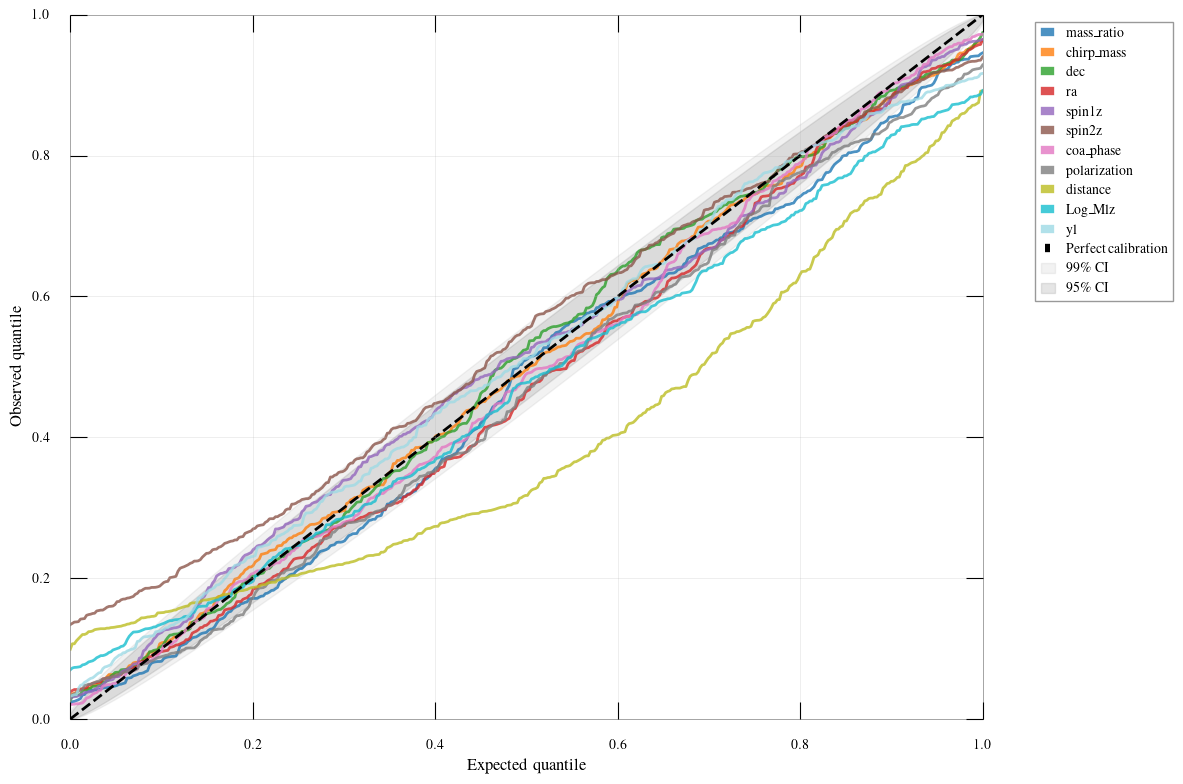

In [47]:
plot_overlay_pp_plot(pp_values, parameter_names, confidence_level=0.95)

In [5]:
posterior_samples_np[-2]

array([ 0.9801434 ,  0.7765895 ,  0.7381181 ,  0.5117037 ,
        0.69488907, -0.01385415,  0.8974244 ,  0.8261314 ,
        0.05890587,  0.10439213,  1.1656778 ], dtype=float32)

In [6]:
posterior_samples_denorm[-2]

array([ 9.81809768e-01,  6.89629298e+01,  7.56165590e-01,
        3.21677956e+00,  3.46695969e-01, -9.20129853e-01,
        5.63691577e+00,  2.59348940e+00,  9.42209426e+02,
        2.31652098e+00,  1.15545198e+00])

In [10]:
samples = updated_samples


theta_vals, data_vals = zip(*results)


theta_vals = [list(d.values()) for d in theta_vals]

# --- Begin normalization code ---

# Extract parameter names
param_names = list(samples[0].keys())

# Convert to numpy array
theta_array = np.array(theta_vals)

# Compute min and max per parameter for normalization
param_min = theta_array.min(axis=0)
param_max = theta_array.max(axis=0)

# Define normalization function
def normalize_params(params):
    return (params - param_min) / (param_max - param_min)

# Define denormalization function
def denormalize_params(norm_params):
    return norm_params * (param_max - param_min) + param_min

# Normalize theta parameters
theta_vals_norm = normalize_params(theta_array)

In [17]:
theta_vals_norm[0]

array([0.77425675, 0.84711062, 0.56799328, 0.53119732,
       0.07943477, 0.32503604, 0.82881334, 0.61579316,
       0.04757539, 0.71958741, 0.60238095])

In [2]:
# Evaluation and sampling
theta_test, data_test = next(iter(test_data_loader))
theta_test = theta_test.to(device)
data_test = data_test.to(device)
with torch.no_grad():
    posterior_samples = flow.sample(5000, context=data_test.reshape(tuple(data_test.shape)))

In [35]:
len(posterior_samples[0][:, 10])

updated_posterior_samples = np.zeros((5000, 11))

def denormalize_params(i, norm_params):
    return norm_params * (param_max[i] - param_min[i]) + param_min[i]

for i in range(11):
    updated_posterior_samples[:, i] = denormalize_params(i, posterior_samples[0][:, i].cpu().numpy())

In [45]:
updated_posterior_samples[:, -3]

array([-1.12557837e+03,  3.10444919e+00,  1.24908563e+04, ...,
        1.48318328e+03,  1.11891184e+02,  2.47953754e+02])

In [11]:
# Denormalize posterior samples and true parameters for plotting
posterior_samples_np = posterior_samples.squeeze(0).cpu().numpy()
posterior_samples_denorm = denormalize_params(posterior_samples_np)
# theta_test_denorm = denormalize_params(theta_test.squeeze(0).cpu().numpy())

theta_test_np = theta_test.squeeze(0).cpu().numpy()
theta_test_denorm = denormalize_params(theta_test_np)

In [21]:
param_max, param_min

(array([9.99974798e-01, 8.59434134e+01, 1.55013621e+00,
        6.28055123e+00, 8.97804009e-01, 8.99308018e-01,
        6.27733067e+00, 3.14122359e+00, 1.44000914e+04,
        4.99981628e+00, 9.99955993e-01]),
 array([ 1.04206572e-01,  1.03757842e+01, -1.54390707e+00,
         1.79377257e-04, -8.98833621e-01, -8.98745092e-01,
         3.94906038e-04,  2.44195607e-04,  1.48479882e+01,
         2.00097274e+00,  1.69486905e-02]))

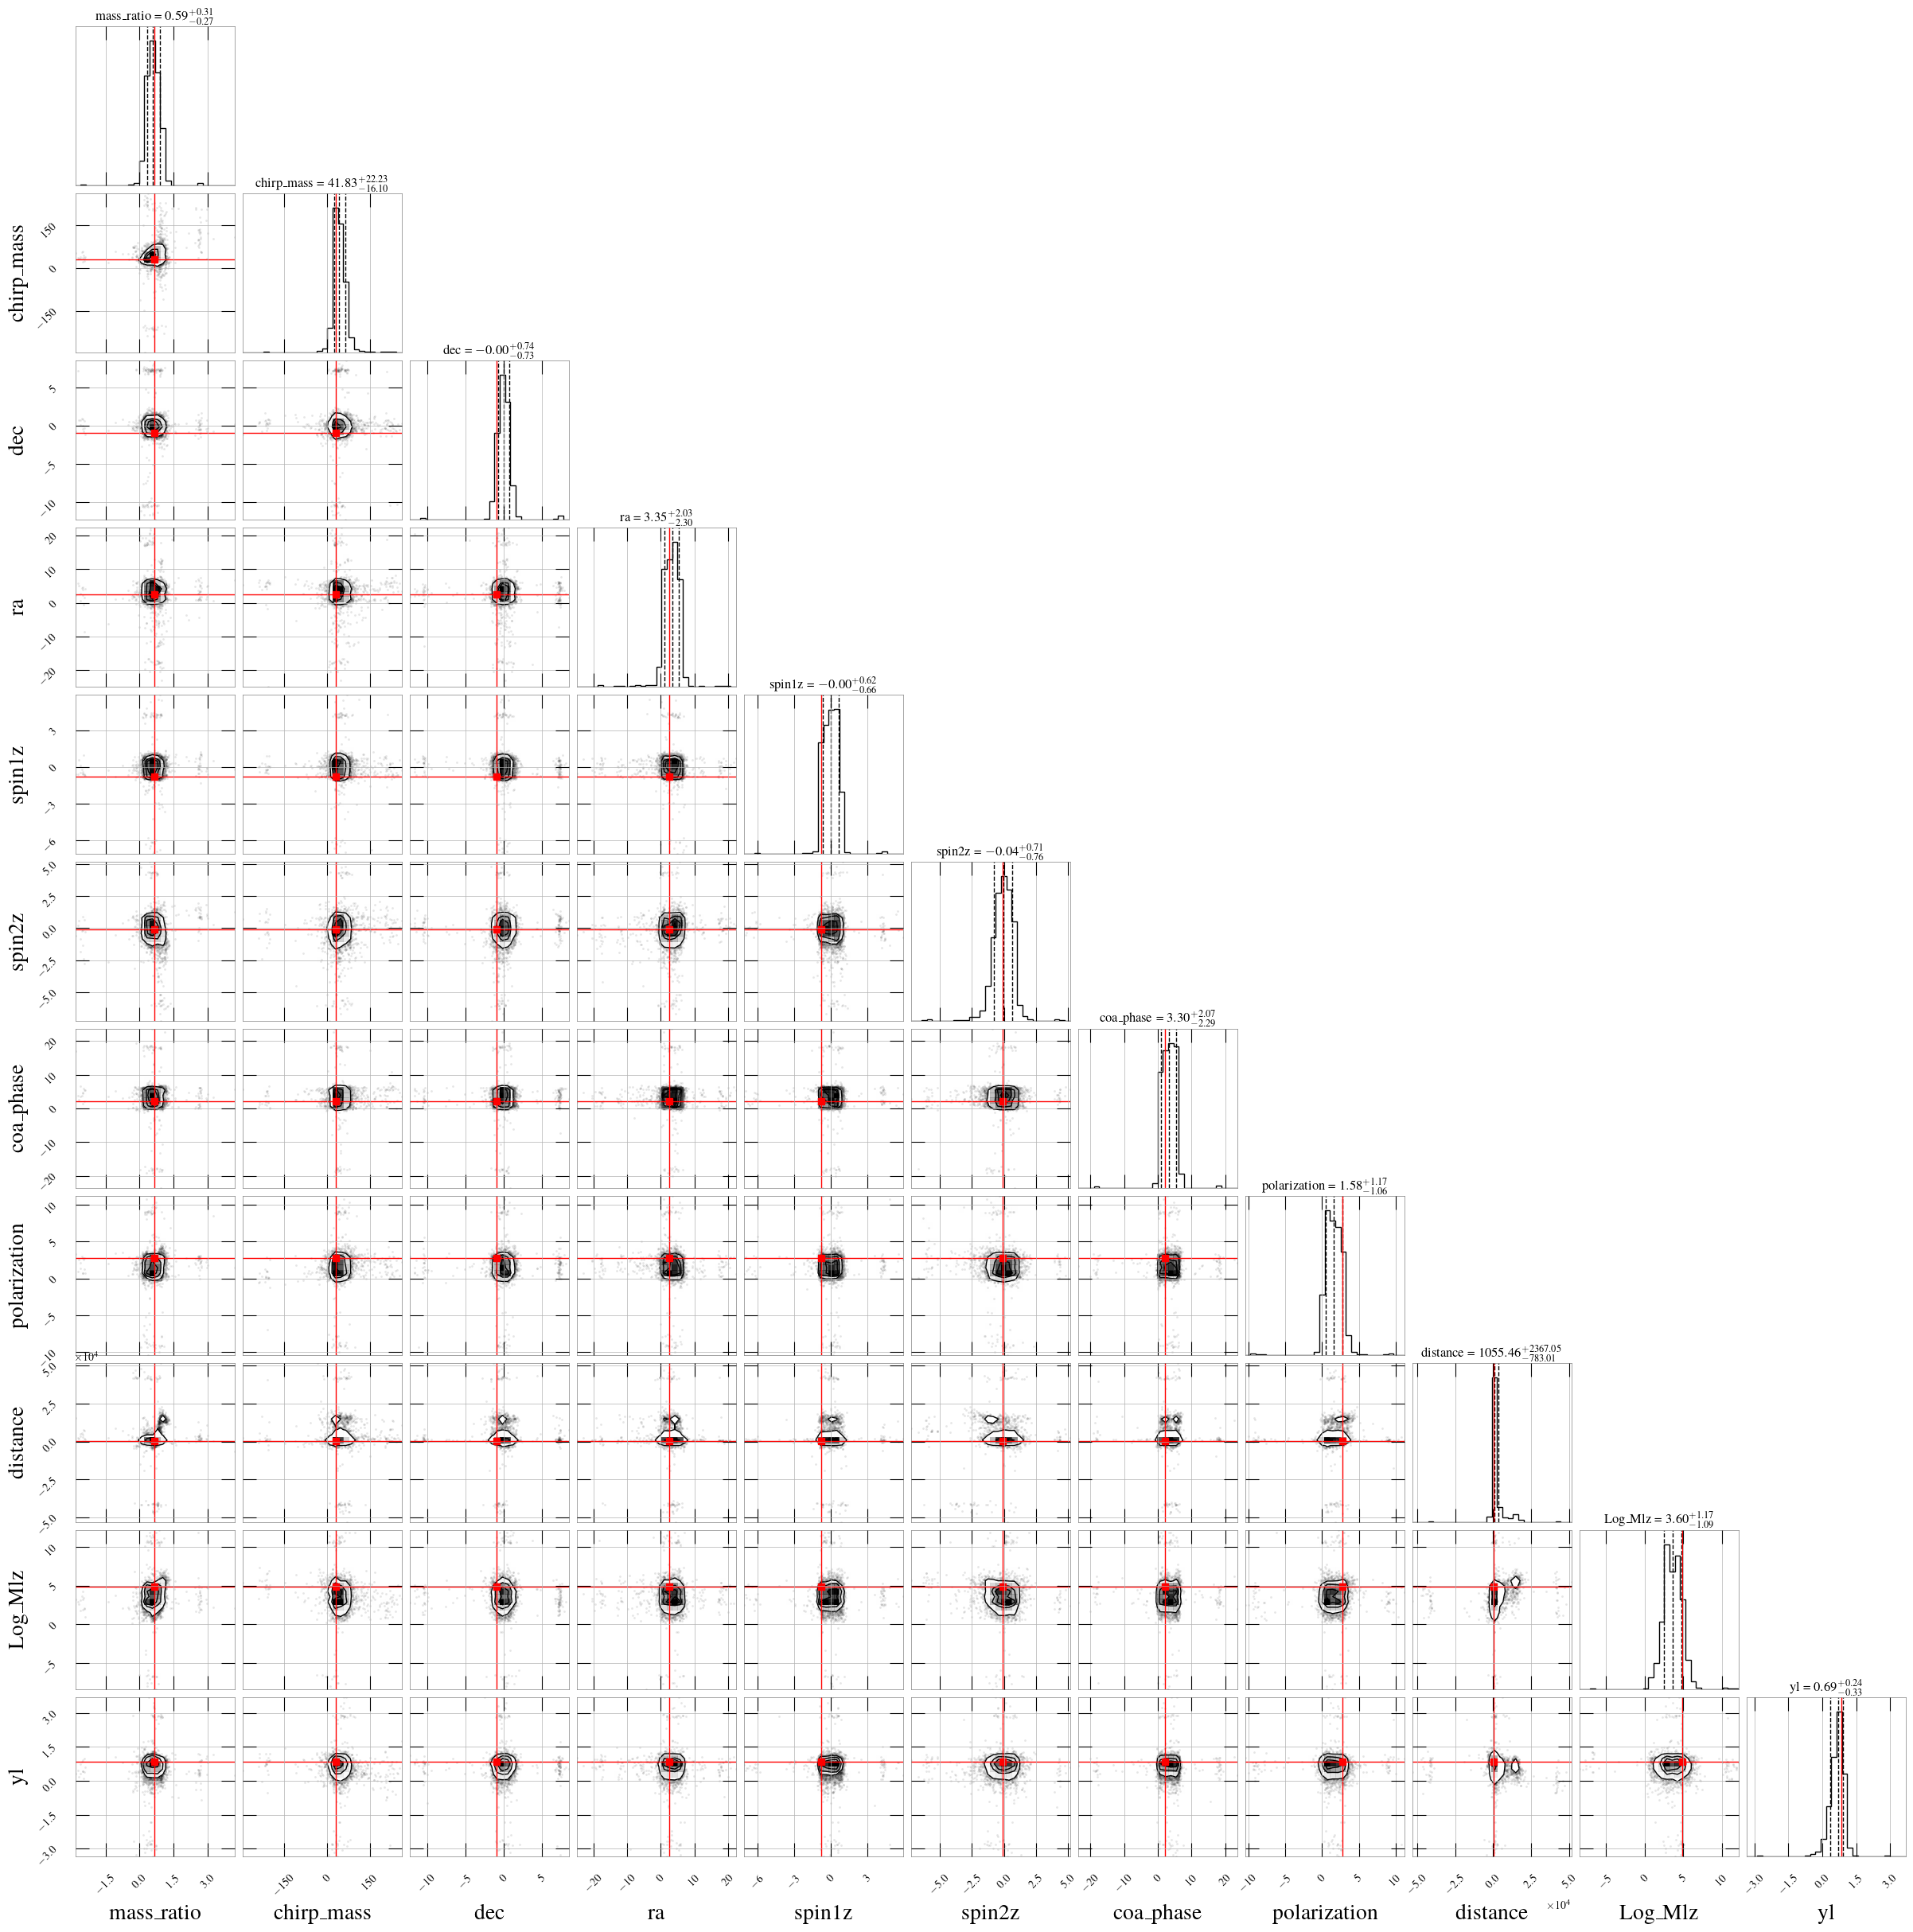

In [38]:
figure = corner.corner(
    updated_posterior_samples,
    bins=30,
    labels=param_names,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    truths=theta_test_denorm,
    truth_color="red",
)

def set_tick_sizes_corner(fig, major=12, minor=7):
    for ax in fig.get_axes():
        for line in ax.xaxis.get_ticklines() + ax.yaxis.get_ticklines():
            line.set_markersize(major)
        for tick in ax.xaxis.get_minor_ticks() + ax.yaxis.get_minor_ticks():
            tick.tick1line.set_markersize(minor)
            tick.tick2line.set_markersize(minor)

set_tick_sizes_corner(figure)

plt.show()

In [12]:
print("Posterior min:", posterior_samples_denorm.min(axis=0))
print("Posterior max:", posterior_samples_denorm.max(axis=0))
print("Truths:", theta_test_denorm)

Posterior min: [-2.84049876e+00 -2.96272401e+02 -1.23042738e+01 -2.50744168e+01
 -7.13243462e+00 -7.25424568e+00 -2.37081045e+01 -1.04221233e+01
 -5.32497653e+04 -8.41984239e+00 -3.36059912e+00]
Posterior max: [4.20235074e+00 2.62323439e+02 8.55679534e+00 2.23592522e+01
 5.91937462e+00 5.15657269e+00 2.35217971e+01 1.11738849e+01
 5.15464635e+04 1.21430543e+01 3.69481300e+00]
Truths: [ 6.52007894e-01  2.99591802e+01 -8.61683368e-01  2.50594586e+00
 -8.07503778e-01 -1.20537051e-01  2.12147671e+00  2.80222553e+00
  4.64114425e+02  4.90071790e+00  8.58474254e-01]
